In [2]:
import pandas as pd
import numpy as np

import string
import re
import datetime
#from datetime import date

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.pylab import rcParams
import seaborn as sns

from jupyter_dash import JupyterDash as Dash
from dash import html 
from flask import Flask
import plotly.express as px

from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

np.random.seed(42)

import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')

In [2]:
# create a new flask app
flask_app = Flask(__name__)

# create a new dash app built on that flask app
dash_app = Dash(__name__, server=flask_app)

# test app
dash_app.layout = html.P("Hello, World!")

In [3]:
dash_app.run_server(mode="inline", height=150, host="localhost", port=5000)

## Load Data

In [3]:
layoffs = pd.read_csv('data/layoffs.csv')
womp_national = pd.read_csv('data/Womply - National - Weekly.csv')
job_postings_national = pd.read_csv('data/Job Postings - National - Weekly.csv')

In [4]:
layoffs.head()

company     location        industry  total_laid_off  \
0             Ola    Bengaluru  Transportation           200.0   
1    Lending Club  SF Bay Area         Finance           225.0   
2       SmartNews        Tokyo           Media           120.0   
3            Pier    Sao Paulo         Finance           111.0   
4  Blockchain.com       London          Crypto           110.0   

   percentage_laid_off        date     stage         country  funds_raised  
0                  NaN  2023-01-13  Series J           India        5000.0  
1                 0.14  2023-01-12       IPO   United States         392.0  
2                 0.13  2023-01-12  Series F   United States         410.0  
3                 0.39  2023-01-12  Series B          Brazil          42.0  
4                 0.28  2023-01-12  Series D  United Kingdom         490.0

In [4]:
layoffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1860 entries, 0 to 1859
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   company              1860 non-null   object 
 1   location             1860 non-null   object 
 2   industry             1854 non-null   object 
 3   total_laid_off       1295 non-null   float64
 4   percentage_laid_off  1255 non-null   float64
 5   date                 1859 non-null   object 
 6   stage                1856 non-null   object 
 7   country              1860 non-null   object 
 8   funds_raised         1719 non-null   float64
dtypes: float64(3), object(6)
memory usage: 130.9+ KB


In [5]:
layoffs = layoffs.dropna(subset=['total_laid_off']).reset_index(drop=True)
display(layoffs.head())
layoffs.shape

company     location        industry  total_laid_off  \
0             Ola    Bengaluru  Transportation           200.0   
1    Lending Club  SF Bay Area         Finance           225.0   
2       SmartNews        Tokyo           Media           120.0   
3            Pier    Sao Paulo         Finance           111.0   
4  Blockchain.com       London          Crypto           110.0   

   percentage_laid_off        date     stage         country  funds_raised  
0                  NaN  2023-01-13  Series J           India        5000.0  
1                 0.14  2023-01-12       IPO   United States         392.0  
2                 0.13  2023-01-12  Series F   United States         410.0  
3                 0.39  2023-01-12  Series B          Brazil          42.0  
4                 0.28  2023-01-12  Series D  United Kingdom         490.0

(1350, 9)

In [140]:
layoffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1350 entries, 0 to 1349
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   company              1350 non-null   object 
 1   location             1350 non-null   object 
 2   industry             1350 non-null   object 
 3   total_laid_off       1350 non-null   float64
 4   percentage_laid_off  1018 non-null   float64
 5   date                 1350 non-null   object 
 6   stage                1349 non-null   object 
 7   country              1350 non-null   object 
 8   funds_raised         1259 non-null   float64
dtypes: float64(3), object(6)
memory usage: 95.0+ KB


In [6]:
layoffs = layoffs.dropna(subset=['industry', 'stage']).reset_index(drop=True)
layoffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1349 entries, 0 to 1348
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   company              1349 non-null   object 
 1   location             1349 non-null   object 
 2   industry             1349 non-null   object 
 3   total_laid_off       1349 non-null   float64
 4   percentage_laid_off  1017 non-null   float64
 5   date                 1349 non-null   object 
 6   stage                1349 non-null   object 
 7   country              1349 non-null   object 
 8   funds_raised         1259 non-null   float64
dtypes: float64(3), object(6)
memory usage: 95.0+ KB


In [7]:
layoffs[layoffs['percentage_laid_off'].isna()]

company        location        industry  total_laid_off  \
0                   Ola       Bengaluru  Transportation           200.0   
6     Cashfree Payments       Bengaluru         Finance           100.0   
8          Career Karma     SF Bay Area       Education            22.0   
14              CoinDCX          Mumbai          Crypto            80.0   
15            HashiCorp     SF Bay Area        Security            69.0   
...                 ...             ...             ...             ...   
1335               Peek  Salt Lake City          Travel            45.0   
1337             Yonder          Austin           Media            18.0   
1338             Bounce       Bengaluru  Transportation           120.0   
1341               Lola          Boston          Travel            34.0   
1348           EasyPost  Salt Lake City       Logistics            75.0   

      percentage_laid_off        date     stage        country  funds_raised  
0                     NaN  2023-01-13  Series J          India        5000.0  
6                     NaN  2023-01-12  Series B          India          41.0  
8                     NaN  2023-01-12  Series B  United States          51.0  
14                    NaN  2023-01-11  Series D          India         244.0  
15                    NaN  2023-01-11       IPO  United States         349.0  
...                   ...         ...       ...            ...           ...  
1335                  NaN  2020-03-20  Series B  United States          39.0  
1337                  NaN  2020-03-20  Series A  United States          16.0  
1338                  NaN  2020-03-19  Series D          India         214.0  
1341                  NaN  2020-03-19  Series C  United States          81.0  
1348                  NaN  2020-03-11  Series A  United States          12.0  

[332 rows x 9 columns]

In [ ]:
# need dataset with company size to get missing percentage laid off

In [8]:
display(womp_national.head())
womp_national.info()

year  month  day_endofweek  merchants_all  revenue_all  \
0  2020      1             12        0.00934    -0.005230   
1  2020      1             19       -0.00367     0.000584   
2  2020      1             26       -0.00330     0.013900   
3  2020      2              2       -0.00259    -0.001570   
4  2020      2              9       -0.00444    -0.002180   

   merchants_professional  revenue_professional  merchants_health  \
0                0.004080             -0.011100           0.00811   
1               -0.004330             -0.000985          -0.00287   
2                0.000051              0.017900          -0.00288   
3                0.000253              0.002670          -0.00262   
4               -0.003930              0.010900          -0.00329   

   revenue_health  merchants_food_accommodation  ...  \
0        -0.00508                       0.00998  ...   
1        -0.01670                      -0.00220  ...   
2         0.02300                      -0.00435  ...   
3         0.00464                      -0.00369  ...   
4         0.00727                      -0.00351  ...   

   merchants_other_services  revenue_other_services  merchants_retail  \
0                   0.00902                0.009850           0.01120   
1                  -0.00380                0.000038          -0.00553   
2                  -0.00341                0.001940          -0.00323   
3                  -0.00234               -0.007390          -0.00305   
4                  -0.00557               -0.010200          -0.00485   

   revenue_retail  revenue_inclow  merchants_inclow  revenue_incmiddle  \
0        -0.01190       -0.005310          0.010500           0.007290   
1        -0.01390        0.015900         -0.002260          -0.010600   
2         0.01960        0.026800         -0.001270           0.018200   
3         0.00948        0.002370         -0.000103           0.000269   
4        -0.00721        0.000047         -0.002570           0.008100   

   merchants_incmiddle  revenue_inchigh  merchants_inchigh  
0             0.011800         0.004880            0.01060  
1            -0.003320        -0.000157           -0.00172  
2            -0.002650         0.011300           -0.00213  
3            -0.000814        -0.000271           -0.00271  
4            -0.002160         0.001460           -0.00289  

[5 rows x 21 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109 entries, 0 to 108
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   year                          109 non-null    int64  
 1   month                         109 non-null    int64  
 2   day_endofweek                 109 non-null    int64  
 3   merchants_all                 109 non-null    float64
 4   revenue_all                   109 non-null    float64
 5   merchants_professional        109 non-null    float64
 6   revenue_professional          109 non-null    float64
 7   merchants_health              109 non-null    float64
 8   revenue_health                109 non-null    float64
 9   merchants_food_accommodation  109 non-null    float64
 10  revenue_food_accommodation    109 non-null    float64
 11  merchants_other_services      109 non-null    float64
 12  revenue_other_services        109 non-null    float64
 13  merch

In [9]:
date = []
for y, m, d in zip(womp_national.year, 
                   womp_national.month, 
                   womp_national.day_endofweek):
    
    date.append(datetime.date(y, m, d))

womp_national['date'] = date

In [10]:
display(job_postings_national.head())
job_postings_national.info()

year  month  day_endofweek  bg_posts  bg_posts_ss30  bg_posts_ss55  \
0  2020      1             10   -0.0407        -0.0748        -0.0399   
1  2020      1             17    0.1180         0.0922         0.0660   
2  2020      1             24   -0.0954        -0.0819        -0.1020   
3  2020      1             31    0.0183         0.0645         0.0758   
4  2020      2              7   -0.0943        -0.1200        -0.0350   

   bg_posts_ss60  bg_posts_ss65  bg_posts_ss70  bg_posts_jz1  \
0         -0.104        -0.1020        0.00711        0.0629   
1          0.170         0.2240        0.07930        0.0934   
2         -0.117        -0.1520       -0.02490       -0.0591   
3          0.051         0.0292       -0.06150       -0.0973   
4         -0.121        -0.0890       -0.09110       -0.0294   

   bg_posts_jzgrp12  bg_posts_jz2  bg_posts_jz3  bg_posts_jzgrp345  \
0           -0.0013      -0.00683       -0.0723            -0.0646   
1            0.1120       0.11400        0.1730             0.1260   
2           -0.0570      -0.05680       -0.1170            -0.1150   
3           -0.0538      -0.05010        0.0168             0.0535   
4           -0.0901      -0.09540       -0.1030            -0.1000   

   bg_posts_jz4  bg_posts_jz5  
0       -0.0512       -0.0889  
1        0.0656        0.2060  
2       -0.0985       -0.1640  
3        0.0841        0.0465  
4       -0.0933       -0.1140

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   year               156 non-null    int64  
 1   month              156 non-null    int64  
 2   day_endofweek      156 non-null    int64  
 3   bg_posts           156 non-null    float64
 4   bg_posts_ss30      156 non-null    float64
 5   bg_posts_ss55      156 non-null    float64
 6   bg_posts_ss60      156 non-null    float64
 7   bg_posts_ss65      156 non-null    float64
 8   bg_posts_ss70      156 non-null    float64
 9   bg_posts_jz1       156 non-null    float64
 10  bg_posts_jzgrp12   156 non-null    float64
 11  bg_posts_jz2       156 non-null    float64
 12  bg_posts_jz3       156 non-null    float64
 13  bg_posts_jzgrp345  156 non-null    float64
 14  bg_posts_jz4       156 non-null    float64
 15  bg_posts_jz5       156 non-null    float64
dtypes: float64(13), int64(3)
m

In [10]:
# job_postings_national['date'] = []
# job_postings_national.loc[4, 'month']

# str(job_postings_national['year'][0]) + \
# '-' + str(job_postings_national['month'][0]) + \
# '-' + str(job_postings_national['day_endofweek'][0])

date = []
for y, m, d in zip(job_postings_national.year, 
                   job_postings_national.month, 
                   job_postings_national.day_endofweek):
    
    date.append(datetime.date(y, m, d))

job_postings_national['date'] = date

## EDA

In [11]:
fig = px.line(job_postings_national, x="date", y="bg_posts", title='Job Postings')
fig.show()

In [12]:
fig = px.line(womp_national, x="date", y="merchants_all", 
              title='Percent change in number of small businesses open, relative to Jan 2020')
fig.show()

In [13]:
fig = px.line(womp_national, x="date", y="revenue_all", 
              title='Percent change in net revenue for small businesses, relative to Jan 2020')
fig.show()

In [14]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=womp_national['date'], y=womp_national['merchants_all'], name="Business Openings", mode='lines'),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=womp_national['date'], y=womp_national['revenue_all'], name="Revenue", mode='lines'),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="Small Business Openings and Revenues, Relative to Jan 2020"
)

# Set x-axis title
fig.update_xaxes(title_text="Date")

# Set y-axes titles
fig.update_yaxes(title_text="Small Business <b>Openings</b>", secondary_y=False)
fig.update_yaxes(title_text="Small Business <b>Revenues</b>", secondary_y=True)

fig.show()

In [15]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=womp_national['date'], y=womp_national['merchants_all'], 
               name="Business Openings", mode='lines'),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=job_postings_national['date'], y=job_postings_national['bg_posts'], 
               name="Job Postings", mode='lines'),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="Small Business Openings and Job Postings, Relative to Jan 2020"
)

# Set x-axis title
fig.update_xaxes(title_text="Date")

# Set y-axes titles
fig.update_yaxes(title_text="Small Business Openings", secondary_y=False)
fig.update_yaxes(title_text="Job Postings", secondary_y=True)

fig.show()

In [16]:
layoffs['day'] = [datetime.datetime.strptime(day, '%Y-%m-%d') for day in layoffs['date']]
layoffs['month'] = [pd.to_datetime(pd.to_datetime(day).strftime('%Y-%m')) for day in layoffs['date']]
# pd.to_datetime(datetime.datetime.strftime(layoffs['day'][0], "%m-%Y")) # another way

layoffs.head()

company     location        industry  total_laid_off  \
0             Ola    Bengaluru  Transportation           200.0   
1    Lending Club  SF Bay Area         Finance           225.0   
2       SmartNews        Tokyo           Media           120.0   
3            Pier    Sao Paulo         Finance           111.0   
4  Blockchain.com       London          Crypto           110.0   

   percentage_laid_off        date     stage         country  funds_raised  \
0                  NaN  2023-01-13  Series J           India        5000.0   
1                 0.14  2023-01-12       IPO   United States         392.0   
2                 0.13  2023-01-12  Series F   United States         410.0   
3                 0.39  2023-01-12  Series B          Brazil          42.0   
4                 0.28  2023-01-12  Series D  United Kingdom         490.0   

         day      month  
0 2023-01-13 2023-01-01  
1 2023-01-12 2023-01-01  
2 2023-01-12 2023-01-01  
3 2023-01-12 2023-01-01  
4 2023-01-12 2023-01-01

In [144]:
layoffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1349 entries, 0 to 1348
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   company              1349 non-null   object        
 1   location             1349 non-null   object        
 2   industry             1349 non-null   object        
 3   total_laid_off       1349 non-null   float64       
 4   percentage_laid_off  1017 non-null   float64       
 5   date                 1349 non-null   object        
 6   stage                1349 non-null   object        
 7   country              1349 non-null   object        
 8   funds_raised         1259 non-null   float64       
 9   day                  1349 non-null   datetime64[ns]
 10  month                1349 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(3), object(6)
memory usage: 116.1+ KB


In [17]:
layoffs_us = layoffs[layoffs['country']=='United States']
len(layoffs_us)

858

In [18]:
total_layoffs_by_date = layoffs[['total_laid_off', 'date']].groupby(by=['date']).sum().reset_index()
total_layoffs_by_date_us = layoffs_us[['total_laid_off', 'date']].groupby(by=['date']).sum().reset_index()

len(total_layoffs_by_date_us)

304

In [19]:
total_layoffs_by_date_us.head()

date  total_laid_off
0  2020-03-11            75.0
1  2020-03-12            20.0
2  2020-03-13            14.0
3  2020-03-16           146.0
4  2020-03-18             4.0

In [ ]:
# adding count:

In [20]:
total_layoffs_by_month = layoffs[['total_laid_off', 'month']].groupby(by=['month']).sum().reset_index()
total_layoffs_by_month_us = layoffs_us[['total_laid_off', 'month']].groupby(by=['month']).sum().reset_index()

In [21]:
total_layoffs_by_industry = layoffs[['total_laid_off', 'month', 'industry']]. \
groupby(by=['month', 'industry']).sum().reset_index()

total_layoffs_by_industry_us = layoffs_us[['total_laid_off', 'month', 'industry']]. \
groupby(by=['month', 'industry']).sum().reset_index()

In [150]:
total_layoffs_by_industry.head()

month      industry  total_laid_off
0 2020-03-01     Aerospace           451.0
1 2020-03-01  Construction            60.0
2 2020-03-01      Consumer           840.0
3 2020-03-01          Data           230.0
4 2020-03-01     Education            50.0

In [22]:
fig = px.bar(total_layoffs_by_industry, x="month", y="total_laid_off", 
             color="industry", title='Total Layoffs U.S.')
fig.show() # too many colors to be helpful

In [25]:
layoffs[['industry', 'total_laid_off']].groupby(by=['industry']).sum().\
reset_index().sort_values(by='total_laid_off', ascending=False).reset_index(drop=True)[:10]

industry  total_laid_off
0          Retail         36319.0
1  Transportation         30496.0
2        Consumer         29582.0
3         Finance         22530.0
4            Food         20090.0
5     Real Estate         16513.0
6          Travel         15620.0
7      Healthcare         13419.0
8           Sales         11905.0
9       Education         11574.0

In [24]:
top_10_industries = layoffs[['industry', 'total_laid_off']].groupby(by=['industry']).sum().\
reset_index().sort_values(by='total_laid_off', ascending=False).reset_index(drop=True)[:10]

In [26]:
fig = px.bar(top_10_industries, x="industry", y="total_laid_off", title='Total Layoffs by Industry', 
             color_discrete_sequence=["purple"])
fig.show()

In [27]:
layoffs_pct = layoffs.dropna(subset=['percentage_laid_off']).reset_index(drop=True)
layoffs_pct.head()

company     location industry  total_laid_off  percentage_laid_off  \
0    Lending Club  SF Bay Area  Finance           225.0                 0.14   
1       SmartNews        Tokyo    Media           120.0                 0.13   
2            Pier    Sao Paulo  Finance           111.0                 0.39   
3  Blockchain.com       London   Crypto           110.0                 0.28   
4      Greenlight      Atlanta  Finance           104.0                 0.21   

         date     stage         country  funds_raised        day      month  
0  2023-01-12       IPO   United States         392.0 2023-01-12 2023-01-01  
1  2023-01-12  Series F   United States         410.0 2023-01-12 2023-01-01  
2  2023-01-12  Series B          Brazil          42.0 2023-01-12 2023-01-01  
3  2023-01-12  Series D  United Kingdom         490.0 2023-01-12 2023-01-01  
4  2023-01-12  Series D   United States         556.0 2023-01-12 2023-01-01

In [28]:
industry_top10_pct = layoffs[['industry', 'percentage_laid_off']].groupby(by=['industry']).mean() \
.reset_index().sort_values(by='percentage_laid_off', ascending=False) \
.reset_index(drop=True)[:10]

In [29]:
fig = px.bar(industry_top10_pct, x="industry", y="percentage_laid_off", 
             title='Layoffs by Industry, Average Percent Laid Off', 
             color_discrete_sequence=["purple"])
fig.show()

In [30]:
layoffs_by_co = layoffs[['company', 'total_laid_off', 'percentage_laid_off']].\
groupby(by=['company']).sum().reset_index()

In [23]:
#total_layoffs_by_month_us = layoffs_us[['total_laid_off', 'month']].groupby(by=['month']).agg([np.sum, 'count']).reset_index()
#total_layoffs_by_month_us.head() # need to flatten

In [31]:
fig = px.bar(total_layoffs_by_month_us, x="month", y="total_laid_off", title='Total Layoffs U.S.', 
             color_discrete_sequence=["red"])
fig.show()

In [32]:
fig = px.bar(total_layoffs_by_month, x="month", y="total_laid_off", title='Total Layoffs, Globally', 
             color_discrete_sequence=["red"])
fig.show()
# color for U.S. or International
# show count of companies 

In [33]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Bar(x=total_layoffs_by_month_us['month'], 
           y=total_layoffs_by_month_us['total_laid_off'], 
           name="Layoffs"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=job_postings_national['date'], y=job_postings_national['bg_posts'], 
               name="Job Postings", mode='lines'),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="Layoffs and Job Postings"
)

# Set x-axis title
fig.update_xaxes(title_text="Date")

# Set y-axes titles
fig.update_yaxes(title_text="Layoffs", secondary_y=False)
fig.update_yaxes(title_text="Job Postings, Relative to Jan 2020", secondary_y=True)

fig.show()

### Time Series Forecast - Layoffs

In [66]:
total_layoffs_by_month.head()

month  total_laid_off
0 2020-03-01          9628.0
1 2020-04-01         26710.0
2 2020-05-01         25804.0
3 2020-06-01          7627.0
4 2020-07-01          7112.0

In [35]:
df_monthly = total_layoffs_by_month

# Make sure that index is DatetimeIndex named "date"
if isinstance(df_monthly.index, pd.DatetimeIndex):
    df_monthly.index.name = 'date'
else:
    df_monthly.rename(columns={'index':'date'}, inplace=True)
    df_monthly.set_index('month', inplace=True)

In [36]:
isinstance(df_monthly.index, pd.DatetimeIndex)

True

In [40]:
df_monthly = df_monthly.asfreq('MS')
df_monthly = df_monthly.fillna(df_monthly.bfill())
df_monthly = df_monthly['total_laid_off'].resample('MS').mean()

In [41]:
df_monthly.head()

month
2020-03-01     9628.0
2020-04-01    26710.0
2020-05-01    25804.0
2020-06-01     7627.0
2020-07-01     7112.0
Freq: MS, Name: total_laid_off, dtype: float64

In [42]:
df_weekly = layoffs[['day', 'total_laid_off']]

# Make sure that index is DatetimeIndex named "date"
if isinstance(df_weekly.index, pd.DatetimeIndex):
    df_weekly.index.name = 'date'
else:
    df_weekly.rename(columns={'index':'date'}, inplace=True)
    df_weekly.set_index('day', inplace=True)
    
    
df_weekly = df_weekly['total_laid_off'].resample('W').sum()
df_weekly.head()

day
2020-03-15     109.0
2020-03-22    1315.0
2020-03-29    6400.0
2020-04-05    6643.0
2020-04-12    6652.0
Freq: W-SUN, Name: total_laid_off, dtype: float64

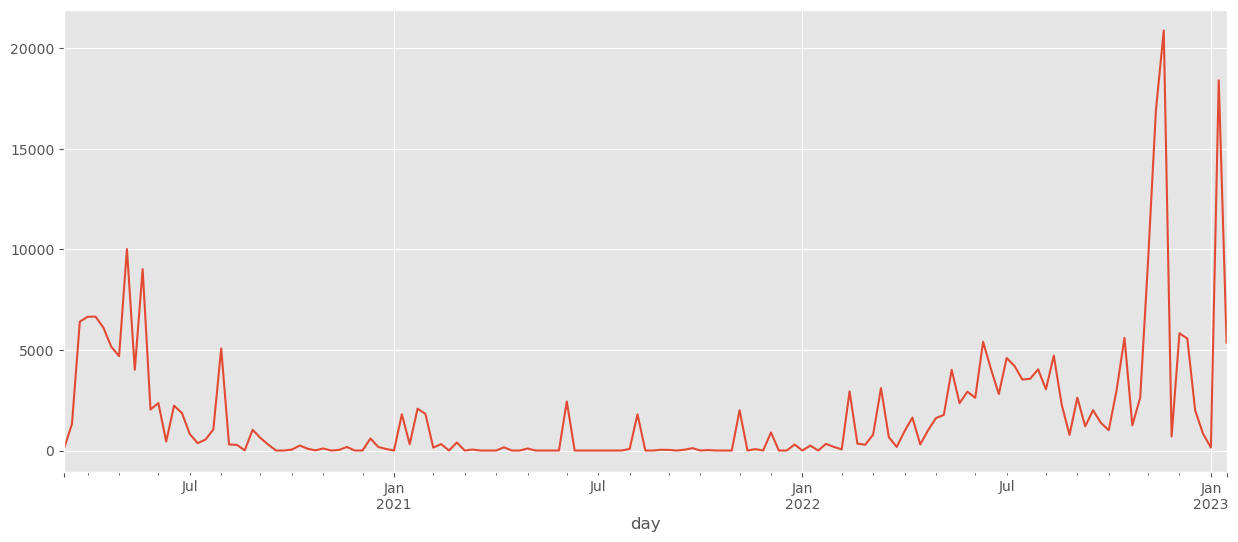

day
2020-03-15     109.0
2020-03-22    1315.0
2020-03-29    6400.0
2020-04-05    6643.0
2020-04-12    6652.0
Freq: W-SUN, Name: total_laid_off, dtype: float64


In [44]:
df_weekly.plot(figsize=(15, 6))
plt.show()
print(df_weekly.head())

<AxesSubplot: >

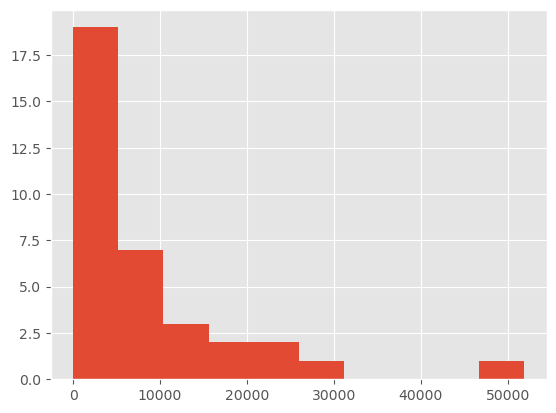

In [45]:
df_monthly.hist()

<AxesSubplot: >

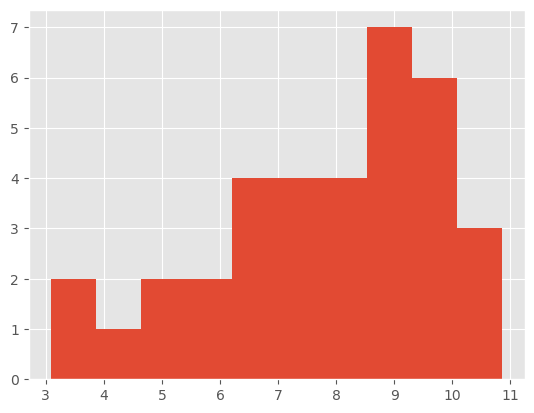

In [46]:
np.log(df_monthly).hist()

In [47]:
df_log = np.log(df_monthly)
df_log.head()

month
2020-03-01     9.172431
2020-04-01    10.192793
2020-05-01    10.158285
2020-06-01     8.939450
2020-07-01     8.869539
Freq: MS, Name: total_laid_off, dtype: float64

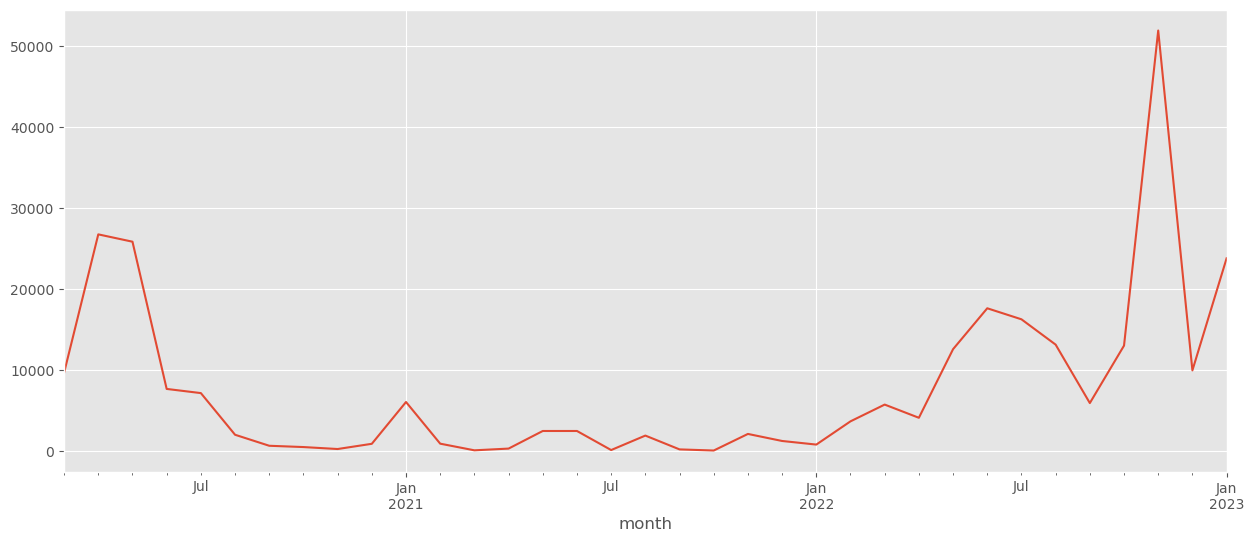

month
2020-03-01     9628.0
2020-04-01    26710.0
2020-05-01    25804.0
2020-06-01     7627.0
2020-07-01     7112.0
Freq: MS, Name: total_laid_off, dtype: float64


In [48]:
df_monthly.plot(figsize=(15, 6))
plt.show()
print(df_monthly.head())

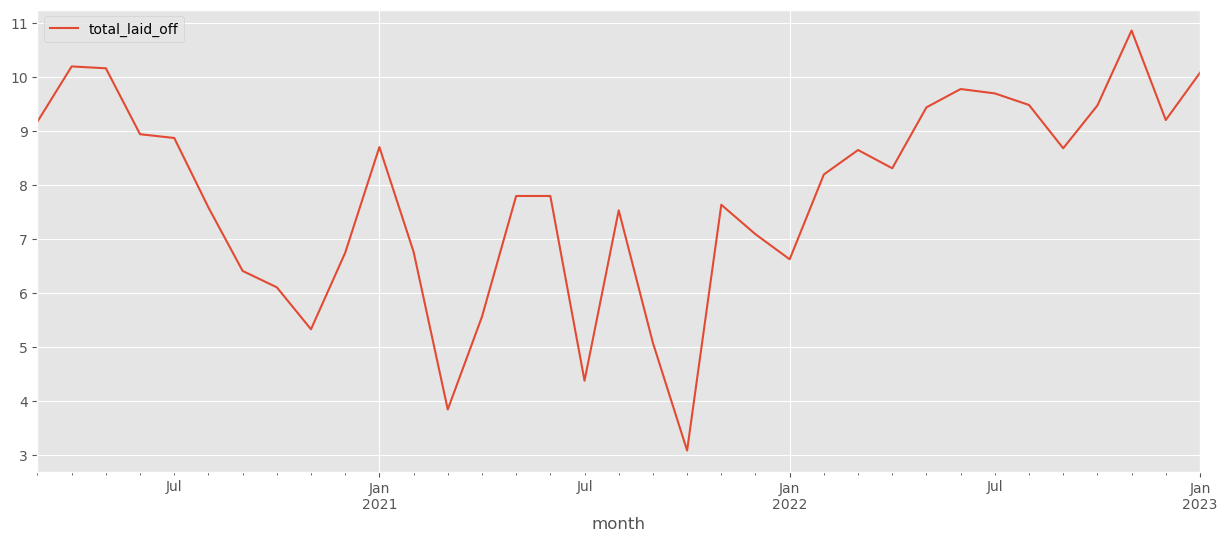

            total_laid_off
month                     
2020-03-01          9628.0
2020-04-01         26710.0
2020-05-01         25804.0
2020-06-01          7627.0
2020-07-01          7112.0


In [180]:
df_log.plot(figsize=(15, 6))
plt.show()
print(df.head())

In [240]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets (use 12 for frequency)
pdqs = [(x[0], x[1], x[2], 4) for x in list(itertools.product(p, d, q))]

In [181]:
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
results = []

for comb in pdq:
    
    for combs in pdqs:
        
        try:
            mod = sm.tsa.statespace.SARIMAX(df_weekly,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_invertibility=False)

            output = mod.fit()
            results.append([comb, combs, output.aic])
            
            print('ARIMA {} x {}: AIC Calculated={}'.format(comb, combs, output.aic))
        
        except: 
            continue

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.63427D+00    |proj g|=  1.77636D-10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   1.776D-10   9.634D+00
  F =   9.6342693855338570     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 0, 0) x (0, 0, 0, 12): AIC Calculated=2873.012276889089
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0        

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.68086D+00    |proj g|=  7.86625D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7      9      1     0     0   3.051D-05   8.681D+00
  F =   8.6808570784641592     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 0, 0) x (1, 1, 1, 12): AIC Calculated=2592.8954093823195
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.47252D+00    |proj g|=  3.98981D-03

At iterate    5    f=  9.47250D+00    |proj g|=  5.91757D-03

At

 This problem is unconstrained.
 This problem is unconstrained.


At iterate   15    f=  9.43271D+00    |proj g|=  3.34165D-02

At iterate   20    f=  9.41090D+00    |proj g|=  3.08648D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     23     28      1     0     0   8.080D-06   9.410D+00
  F =   9.4099555304516134     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 0, 1) x (0, 0, 1, 12): AIC Calculated=2810.166748074581
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.63713D+00    |proj g|=  2.98544D-02

    

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.60173D+00    |proj g|=  3.93053D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      8      1     0     0   3.931D-05   8.602D+00
  F =   8.6017266965801191     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 0, 1) x (0, 1, 1, 12): AIC Calculated=2569.3145555808755
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.42651D+00    |proj g|=  5.62491D-02

At iterate    5    f=  9.42454D+00    |proj g|=  8.88505D-05

At

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  9.42539D+00    |proj g|=  6.76461D-03

At iterate   10    f=  9.42434D+00    |proj g|=  8.89157D-05

At iterate   15    f=  9.42433D+00    |proj g|=  1.16186D-03

At iterate   20    f=  9.42350D+00    |proj g|=  1.32740D-02

At iterate   25    f=  9.40822D+00    |proj g|=  2.17900D-02

At iterate   30    f=  9.39380D+00    |proj g|=  8.33089D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     34     38      1     0     0   8.633D-08   9.394D+00
  F =   9.3937961023296044     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 0, 1) x (1, 0, 1, 12): AIC Calculated=280

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.60158D+00    |proj g|=  8.65924D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      7     13      1     0     0   3.931D-05   8.602D+00
  F =   8.6015772716962680     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 0, 1) x (1, 1, 1, 12): AIC Calculated=2571.270026965488
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.39678D+00    |proj g|=  2.16769D-06

           * * *

Tit   = total number of iterations
Tnf   = tota

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.67025D+00    |proj g|=  5.76847D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5      7      1     0     0   5.768D-05   8.670D+00
  F =   8.6702479898886651     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 0) x (0, 1, 1, 12): AIC Calculated=2587.733900986822
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.38922D+00    |proj g|=  9.37175D-03

           * * *

Tit   = total number of iterations
Tnf   = tota

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.67660D+00    |proj g|=  5.40182D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      4      6      1     0     0   1.085D-05   8.672D+00
  F =   8.6723801267104577     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 0) x (1, 1, 0, 12): AIC Calculated=2588.369277759716
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0        

 This problem is unconstrained.
 This problem is unconstrained.


ARIMA (0, 1, 0) x (1, 1, 1, 12): AIC Calculated=2588.7609478937447
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.27077D+00    |proj g|=  1.07846D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      4      6      1     0     0   9.442D-06   9.259D+00
  F =   9.2589613359480705     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 1, 1) x (0, 0, 0, 12): AIC Calculated=2763.170478112525
RUNNING THE L-BFGS-B CODE

           * * *

Machine precisio

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.58289D+00    |proj g|=  1.03792D-01

At iterate    5    f=  8.53819D+00    |proj g|=  3.02334D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6     10      1     0     0   3.024D-05   8.538D+00
  F =   8.5381863802437028     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 1) x (0, 1, 1, 12): AIC Calculated=2550.3795413126236
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     16      1     0     0   2.448D-05   9.247D+00
  F =   9.2470562467088921     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 1) x (1, 0, 1, 12): AIC Calculated=2763.6227615192497
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.57683D+00    |proj g|=  7.89453D-02

At iterate    5    f=  8.56054D+00    |proj g|=  6.12033D-05

           * * *

Tit   = total number of iterations
Tnf   = tot

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.53907D+00    |proj g|=  1.83105D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     11      1     0     0   3.018D-05   8.538D+00
  F =   8.5381844569417833     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 1) x (1, 1, 1, 12): AIC Calculated=2552.3789681686517
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.36513D+00    |proj g|=  3.31268D-03

           * * *

Tit   = total number of iterations
Tnf   = tot

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  9.33528D+00    |proj g|=  4.18997D-04

At iterate   10    f=  9.33527D+00    |proj g|=  1.05565D-03

At iterate   15    f=  9.33479D+00    |proj g|=  1.24949D-02

At iterate   20    f=  9.33283D+00    |proj g|=  1.57427D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     22     28      1     0     0   1.024D-06   9.333D+00
  F =   9.3328276375949599     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (1, 0, 0) x (0, 0, 1, 12): AIC Calculated=2787.182636003298
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =         

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  8.57532D+00    |proj g|=  3.24976D-03

At iterate   15    f=  8.57438D+00    |proj g|=  1.30564D-02

At iterate   20    f=  8.57413D+00    |proj g|=  1.81366D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     26      1     0     0   1.814D-07   8.574D+00
  F =   8.5741332464634663     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (1, 0, 0) x (0, 1, 1, 12): AIC Calculated=2561.091707446113
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  9.34117D+00    |proj g|=  4.53815D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      8      1     0     0   2.583D-05   9.341D+00
  F =   9.3411746792880059     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 0) x (1, 0, 0, 12): AIC Calculated=2789.6700544278256
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.41787D+00    |proj g|=  2.00875D-01

At iterate    5    f=  9.33722D+00    |proj g|=  2.22112D-02

At

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.58472D+00    |proj g|=  1.61535D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      7      1     0     0   1.615D-05   8.585D+00
  F =   8.5847156979248638     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 0) x (1, 1, 0, 12): AIC Calculated=2564.2452779816094
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.59652D+00    |proj g|=  3.59962D-02

At iterate    5    f=  8.57542D+00    |proj g|=  1.51102D-02

  

 This problem is unconstrained.
 This problem is unconstrained.


ARIMA (1, 0, 1) x (0, 0, 1, 12): AIC Calculated=2780.5726307376935
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.59866D+00    |proj g|=  7.15404D-03

At iterate    5    f=  8.59863D+00    |proj g|=  6.23324D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      9      1     0     0   6.233D-07   8.599D+00
  F =   8.5986299205169505     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (1, 0, 1) x (0, 1, 0, 12): AIC Calculated=2568.391716314051

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     13      1     0     0   2.340D-05   8.567D+00
  F =   8.5670323867023210     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 1) x (0, 1, 1, 12): AIC Calculated=2560.9756512372915
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.33087D+00    |proj g|=  9.11920D-02

At iterate    5    f=  9.31171D+00    |proj g|=  4.19602D-03

At iterate   10    f=  9.31095D+00    |proj g|=  1.05666D-03

  

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  9.30066D+00    |proj g|=  3.74382D-02

At iterate   10    f=  9.29999D+00    |proj g|=  7.17610D-04

At iterate   15    f=  9.29995D+00    |proj g|=  2.87031D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     26      1     0     0   2.870D-05   9.300D+00
  F =   9.2999476179129186     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 1) x (1, 0, 1, 12): AIC Calculated=2781.3843901380496
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.57898D+00    |proj g|=  1.49431D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      7     10      1     0     0   1.377D-05   8.579D+00
  F =   8.5789805447854928     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 1) x (1, 1, 0, 12): AIC Calculated=2564.536202346077
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.59143D+00    |proj g|=  5.07674D-02

At iterate    5    f=  8.56741D+00    |proj g|=  2.19920D-02

At 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  9.29961D+00    |proj g|=  1.67193D-02

At iterate   20    f=  9.29911D+00    |proj g|=  2.55636D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     27      1     0     0   2.556D-06   9.299D+00
  F =   9.2991066970956169     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (1, 1, 0) x (0, 0, 1, 12): AIC Calculated=2777.133795734494
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.61991D+00    |proj g|=  1.11241D-03

   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.31270D+00    |proj g|=  1.06032D-02

At iterate    5    f=  9.31246D+00    |proj g|=  5.52287D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      7      1     0     0   5.523D-06   9.312D+00
  F =   9.3124630460353064     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (1, 1, 0) x (1, 0, 0, 12): AIC Calculated=2781.1139877185215
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      4      6      1     0     0   9.771D-06   8.610D+00
  F =   8.6104175283352546     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (1, 1, 0) x (1, 1, 0, 12): AIC Calculated=2571.904423443906
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.61336D+00    |proj g|=  4.04719D-02

At iterate    5    f=  8.59084D+00    |proj g|=  2.09897D-02

At iterate   10    f=  8.59019D+00    |proj g|=  4.45619D-05

At 

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.24369D+00    |proj g|=  1.65584D-01

At iterate    5    f=  9.23555D+00    |proj g|=  8.84563D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     10      1     0     0   2.125D-05   9.236D+00
  F =   9.2355509568729524     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 1) x (0, 0, 0, 12): AIC Calculated=2758.1941851481397
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.51581D+00    |proj g|=  2.24883D-02

At iterate   10    f=  8.51561D+00    |proj g|=  9.76978D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     16      1     0     0   3.957D-05   8.516D+00
  F =   8.5156088486911443     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 1) x (0, 1, 1, 12): AIC Calculated=2545.651436909961
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.23967D+00    |proj g|=  1.59553D-01

At 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  9.23064D+00    |proj g|=  2.61878D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     14      1     0     0   2.619D-05   9.231D+00
  F =   9.2306394391673479     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 1) x (1, 0, 0, 12): AIC Calculated=2758.73055287187
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.23432D+00    |proj g|=  1.44176D-01

At iterate    5    f=  9.22544D+00    |proj g|=  1.04203D-02

At i

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.55161D+00    |proj g|=  9.53481D-02

At iterate    5    f=  8.52371D+00    |proj g|=  2.93214D-02

At iterate   10    f=  8.51622D+00    |proj g|=  3.85577D-02

At iterate   15    f=  8.51555D+00    |proj g|=  3.93763D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     22      1     0     0   3.938D-05   8.516D+00
  F =   8.5155478547447885     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1

In [182]:
results_df = pd.DataFrame(results, columns=['pdq', 'pdqs', 'aic'])
results_df.loc[results_df['aic'].idxmin()]

pdq         (1, 1, 1)
pdqs    (0, 1, 1, 12)
aic       2545.651437
Name: 59, dtype: object

In [185]:
results_df.loc[results_df['aic'].idxmin()].name

59

In [187]:
order = results_df.iloc[results_df.loc[results_df['aic'].idxmin()].name]['pdq']
seasonal_order = results_df.iloc[results_df.loc[results_df['aic'].idxmin()].name]['pdqs']

In [188]:
# Plug the optimal parameter values into a new SARIMAX model
mod = sm.tsa.statespace.SARIMAX(df_weekly, 
                                order=order,
                                seasonal_order=seasonal_order,
                                enforce_invertibility=False)

            

# Fit the model and print results
output = mod.fit()
print(output.summary().tables[1])

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.56505D+00    |proj g|=  1.28851D-01

At iterate    5    f=  8.51581D+00    |proj g|=  2.24883D-02

At iterate   10    f=  8.51561D+00    |proj g|=  9.76978D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     16      1     0     0   3.957D-05   8.516D+00
  F =   8.5156088486911443     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3217      0.097      3.305      0.001       0.131       0.513
ma.L1         -0.9092      0.070    -12.907      0.000      -1.047      -0.771
ma.S.L12      -0.5850      0.176     -3.321      0.001      -0.930      -0.240
sigma2      8.246e+06   4.42e+05     18.659      0.000    7.38e+06    9.11e+06


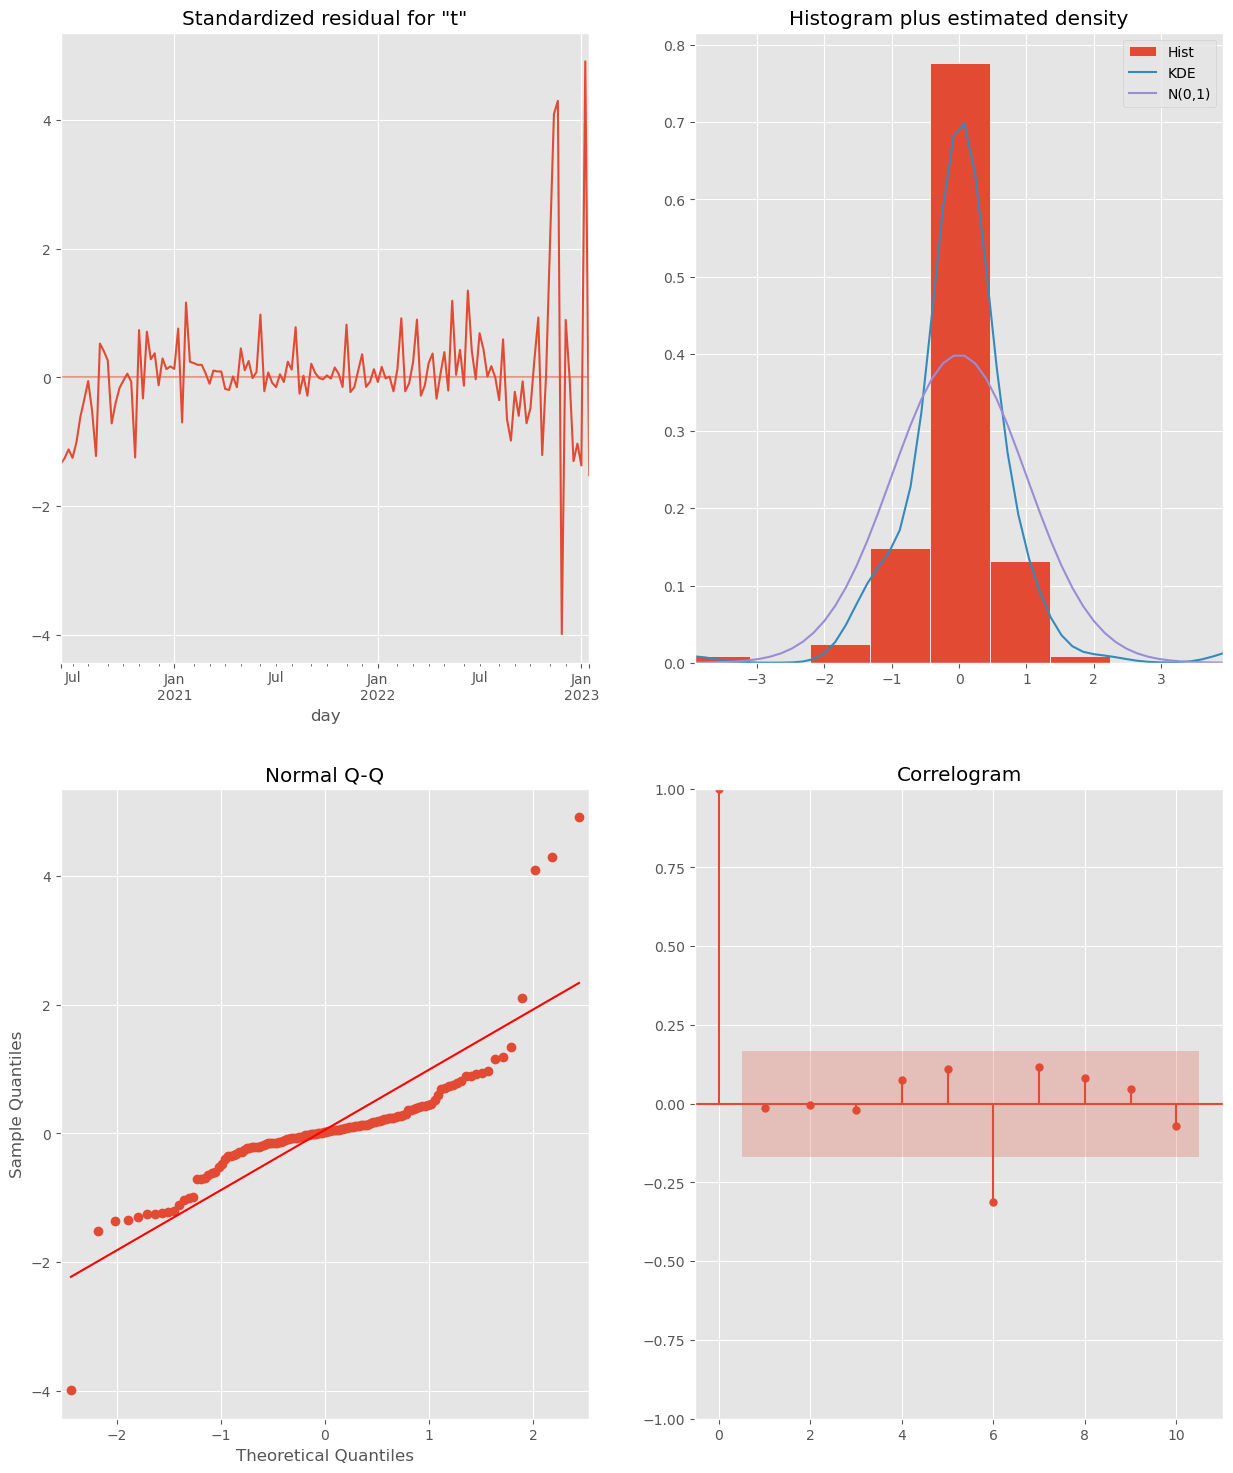

In [189]:
output.plot_diagnostics(figsize=(15, 18))
plt.show()

In [190]:
pred = output.get_prediction(start=pd.to_datetime('2022-01-02'), dynamic=False)
pred_conf = pred.conf_int()

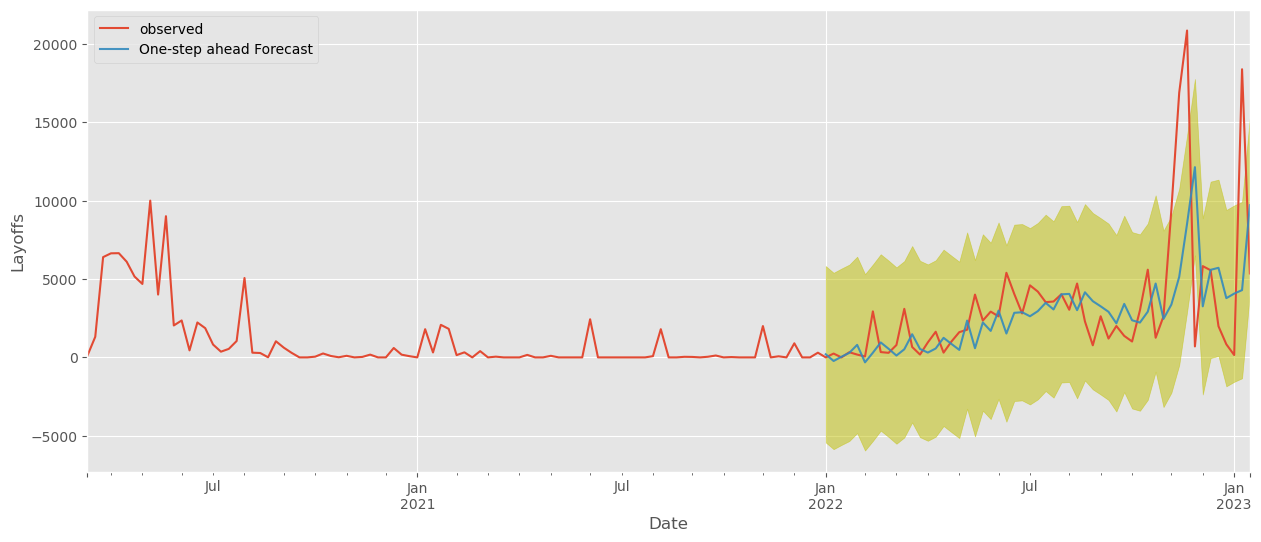

In [191]:
# Plot real vs predicted values along with confidence interval
rcParams['figure.figsize'] = 15, 6 #matplotlib runtime configuration

# Plot observed values
ax = df_weekly.plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='y', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Layoffs')
plt.legend()

plt.show()

### Time Series Forecast - Job Postings

In [49]:
job_postings_national.head()

year  month  day_endofweek  bg_posts  bg_posts_ss30  bg_posts_ss55  \
0  2020      1             10   -0.0407        -0.0748        -0.0399   
1  2020      1             17    0.1180         0.0922         0.0660   
2  2020      1             24   -0.0954        -0.0819        -0.1020   
3  2020      1             31    0.0183         0.0645         0.0758   
4  2020      2              7   -0.0943        -0.1200        -0.0350   

   bg_posts_ss60  bg_posts_ss65  bg_posts_ss70  bg_posts_jz1  \
0         -0.104        -0.1020        0.00711        0.0629   
1          0.170         0.2240        0.07930        0.0934   
2         -0.117        -0.1520       -0.02490       -0.0591   
3          0.051         0.0292       -0.06150       -0.0973   
4         -0.121        -0.0890       -0.09110       -0.0294   

   bg_posts_jzgrp12  bg_posts_jz2  bg_posts_jz3  bg_posts_jzgrp345  \
0           -0.0013      -0.00683       -0.0723            -0.0646   
1            0.1120       0.11400        0.1730             0.1260   
2           -0.0570      -0.05680       -0.1170            -0.1150   
3           -0.0538      -0.05010        0.0168             0.0535   
4           -0.0901      -0.09540       -0.1030            -0.1000   

   bg_posts_jz4  bg_posts_jz5        date  
0       -0.0512       -0.0889  2020-01-10  
1        0.0656        0.2060  2020-01-17  
2       -0.0985       -0.1640  2020-01-24  
3        0.0841        0.0465  2020-01-31  
4       -0.0933       -0.1140  2020-02-07

In [50]:
#Plot rolling statistics
def check_stationarity(df,window,count):
    moving_avg = df.rolling(window).mean() #4 week lag
    moving_std = df.rolling(window).std()

    orig = plt.plot(df, color='blue',label='Original')
    mean = plt.plot(moving_avg, color='red', label='Rolling Mean')
    std = plt.plot(moving_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(count, autolag='AIC')

    # Extract and display test results in a user friendly manner
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
#mean and standard deviation increasing with time = not stationary

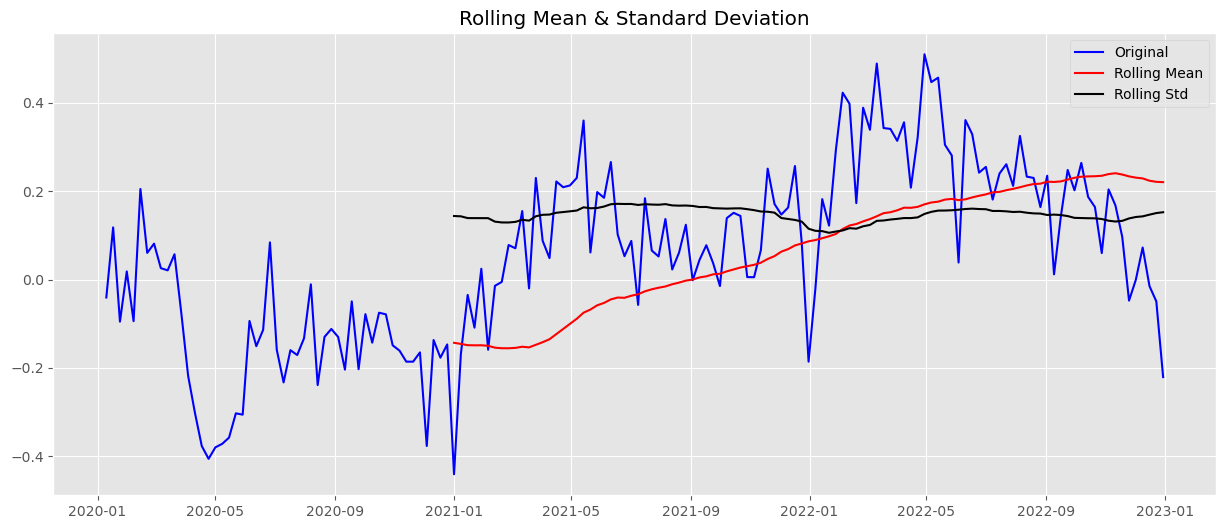

Results of Dickey-Fuller Test:
Test Statistic                  -1.823939
p-value                          0.368643
#Lags Used                       3.000000
Number of Observations Used    152.000000
Critical Value (1%)             -3.474121
Critical Value (5%)             -2.880750
Critical Value (10%)            -2.577013
dtype: float64


In [228]:
df = job_postings_national[['date', 'bg_posts']]

# Make sure that index is DatetimeIndex named "date"
if isinstance(df.index, pd.DatetimeIndex):
    df.index.name = 'date'
else:
    df.rename(columns={'index':'date'}, inplace=True)
    df.set_index('date', inplace=True)
    
    
df = df.asfreq('W-FRI')

# Perform the dickey Fuller test 
check_stationarity(df, 52, df['bg_posts'])

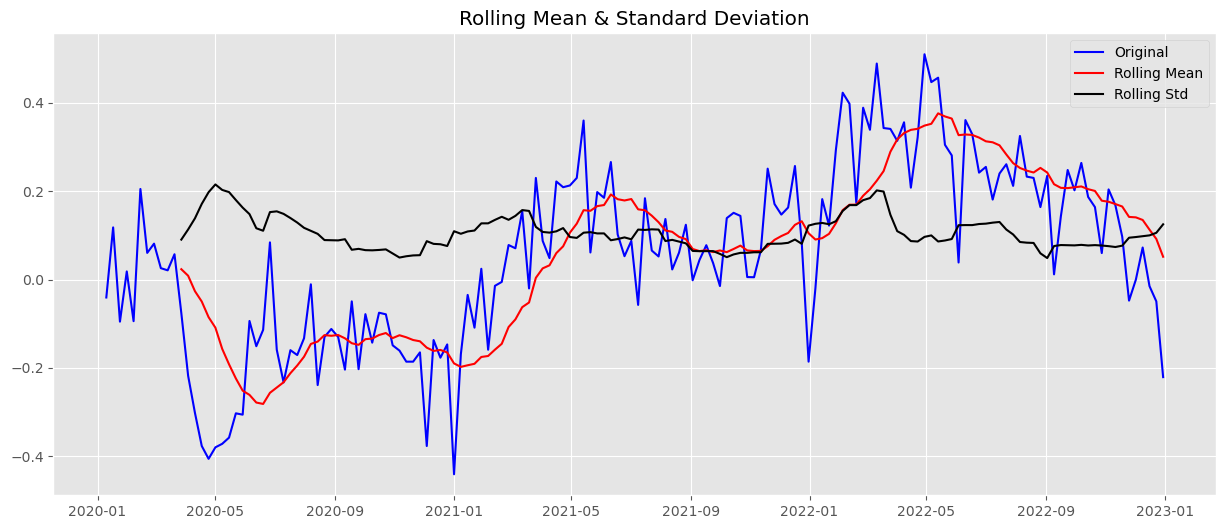

Results of Dickey-Fuller Test:
Test Statistic                  -1.823939
p-value                          0.368643
#Lags Used                       3.000000
Number of Observations Used    152.000000
Critical Value (1%)             -3.474121
Critical Value (5%)             -2.880750
Critical Value (10%)            -2.577013
dtype: float64


In [229]:
# Perform the dickey Fuller test 
check_stationarity(df, 12, df['bg_posts'])

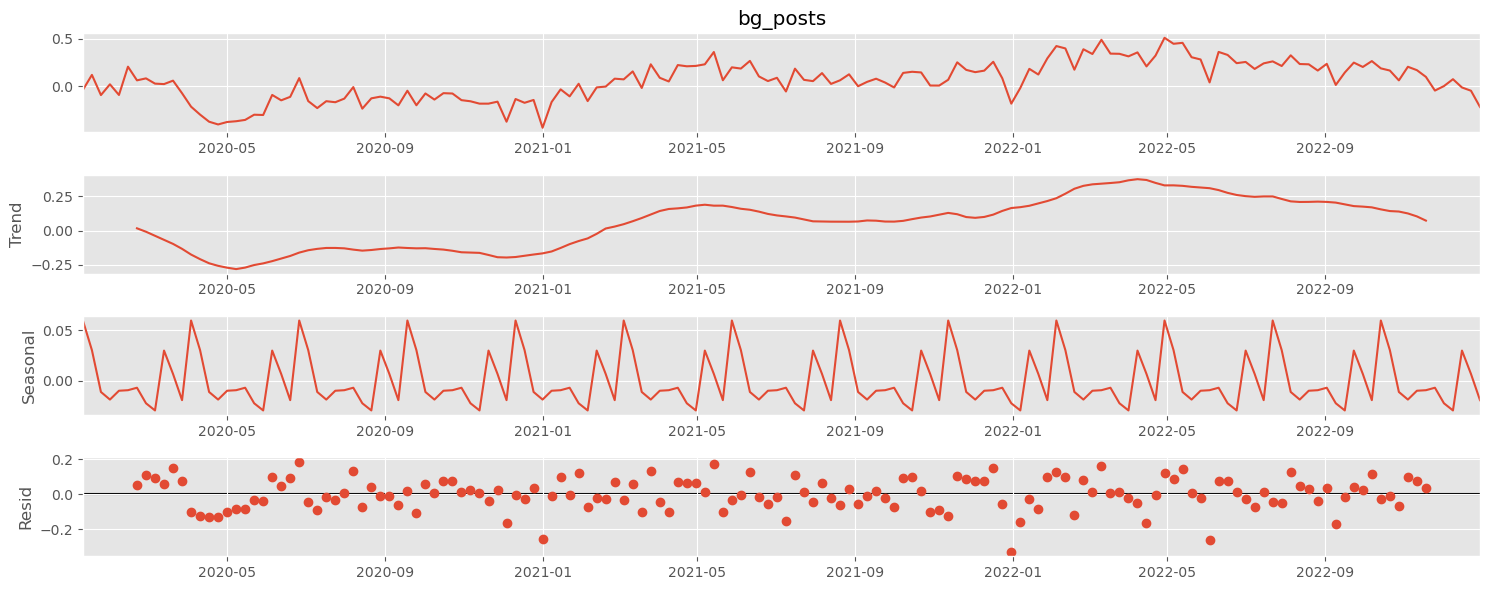

In [176]:
sd = seasonal_decompose(df, period=12)
sd.plot()
plt.show()

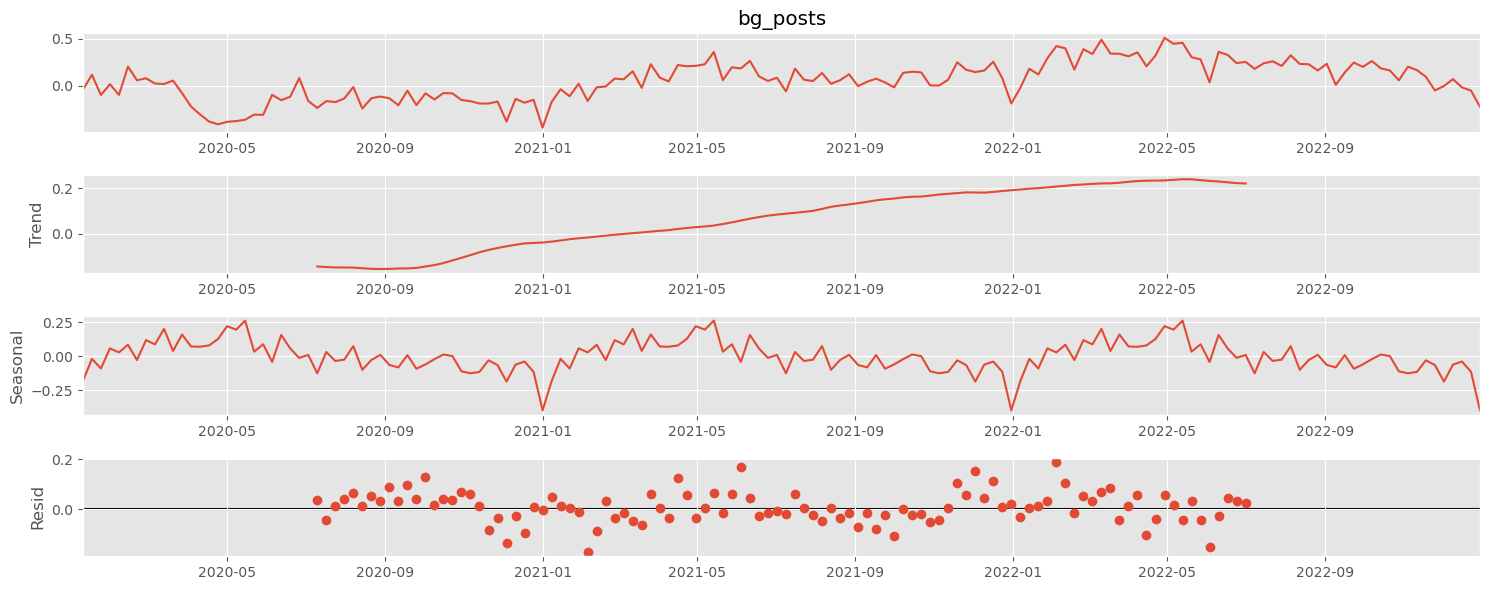

In [175]:
sd = seasonal_decompose(df, period=52)
sd.plot()
plt.show()

In [53]:
df_monthly = df['bg_posts'].resample('MS').mean() # monthly frequency

df = df['bg_posts'].resample('W-FRI').mean()
df = df.fillna(df.bfill())
df.head()

date
2020-01-10   -0.0407
2020-01-17    0.1180
2020-01-24   -0.0954
2020-01-31    0.0183
2020-02-07   -0.0943
Freq: W-FRI, Name: bg_posts, dtype: float64

In [579]:
sd = seasonal_decompose(df_monthly, period=12)
sd.plot()
plt.show()

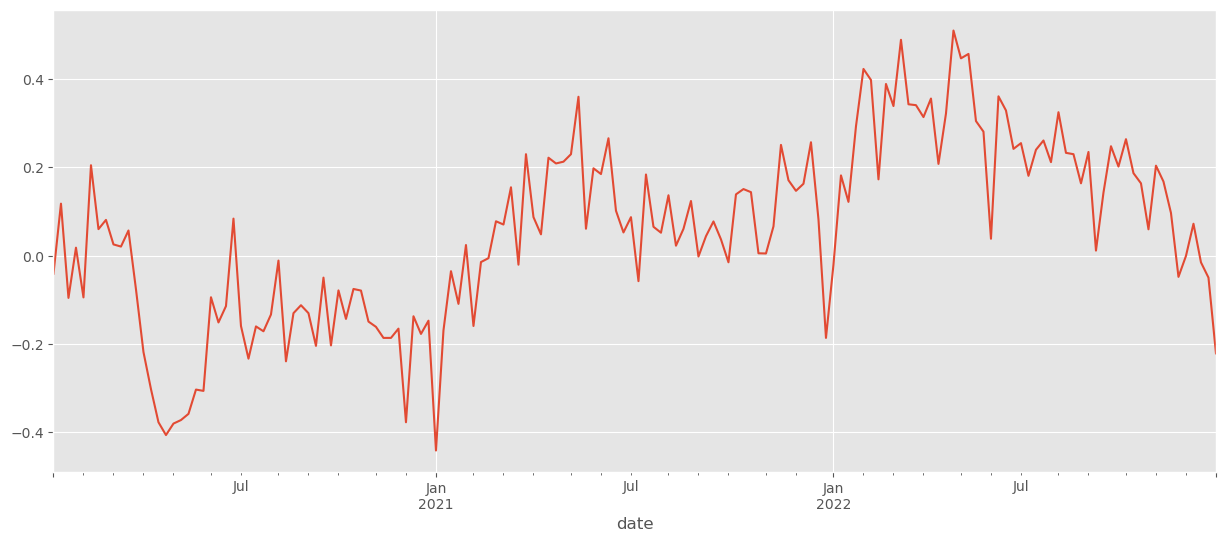

In [54]:
df.plot(figsize=(15, 6))
plt.show()

In [196]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets (use 52 for frequency - yearly)
pdqs = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))]

In [197]:
results = []

for comb in pdq:
    
    for combs in pdqs:
        
        try:
            mod = sm.tsa.statespace.SARIMAX(endog=df,
                                            order=comb,
                                            seasonal_order=combs)
                                            #enforce_invertibility=False, 
                                            #enforce_stationarity=False)

            output = mod.fit()
            results.append([comb, combs, output.aic])
            
            print('ARIMA {} x {}: AIC Calculated={}'.format(comb, combs, output.aic))
        
        except: 
            continue

In [198]:
results_df = pd.DataFrame(results, columns=['pdq', 'pdqs', 'aic'])
results_df.loc[results_df['aic'].idxmin()]

TypeError: reduction operation 'argmin' not allowed for this dtype

In [167]:
order = results_df.iloc[results_df.loc[results_df['aic'].idxmin()].name]['pdq']
seasonal_order = results_df.iloc[results_df.loc[results_df['aic'].idxmin()].name]['pdqs']

In [129]:
#order_52 = results_df.iloc[results_df.loc[results_df['aic'].idxmin()].name]['pdq']
#seasonal_order_52 = results_df.iloc[results_df.loc[results_df['aic'].idxmin()].name]['pdqs']

In [177]:
# Plug the optimal parameter values into a new SARIMAX model
mod = sm.tsa.statespace.SARIMAX(df, 
                                order=order,
                                seasonal_order=seasonal_order)
                                #enforce_invertibility=False, 
                                #enforce_stationarity=False)

# Fit the model and print results
output = mod.fit()
print(output.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.02648D-01    |proj g|=  4.23456D-01


 This problem is unconstrained.



At iterate    5    f= -8.12667D-01    |proj g|=  2.18992D-02

At iterate   10    f= -8.12701D-01    |proj g|=  7.55498D-02

At iterate   15    f= -8.12755D-01    |proj g|=  1.08171D-03

At iterate   20    f= -8.12767D-01    |proj g|=  1.90905D-02

At iterate   25    f= -8.12834D-01    |proj g|=  1.09846D-02

At iterate   30    f= -8.12835D-01    |proj g|=  1.40499D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     38      1     0     0   8.133D-06  -8.128D-01
  F = -0.81283538551282652     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                                      SARIMAX Resul

In [ ]:
# Plug the optimal parameter values into a new SARIMAX model
mod = sm.tsa.statespace.SARIMAX(df, 
                                order=order,
                                seasonal_order=seasonal_order)
                                #enforce_invertibility=False, 
                                #enforce_stationarity=False)

# Fit the model and print results
output = mod.fit()
print(output.summary())

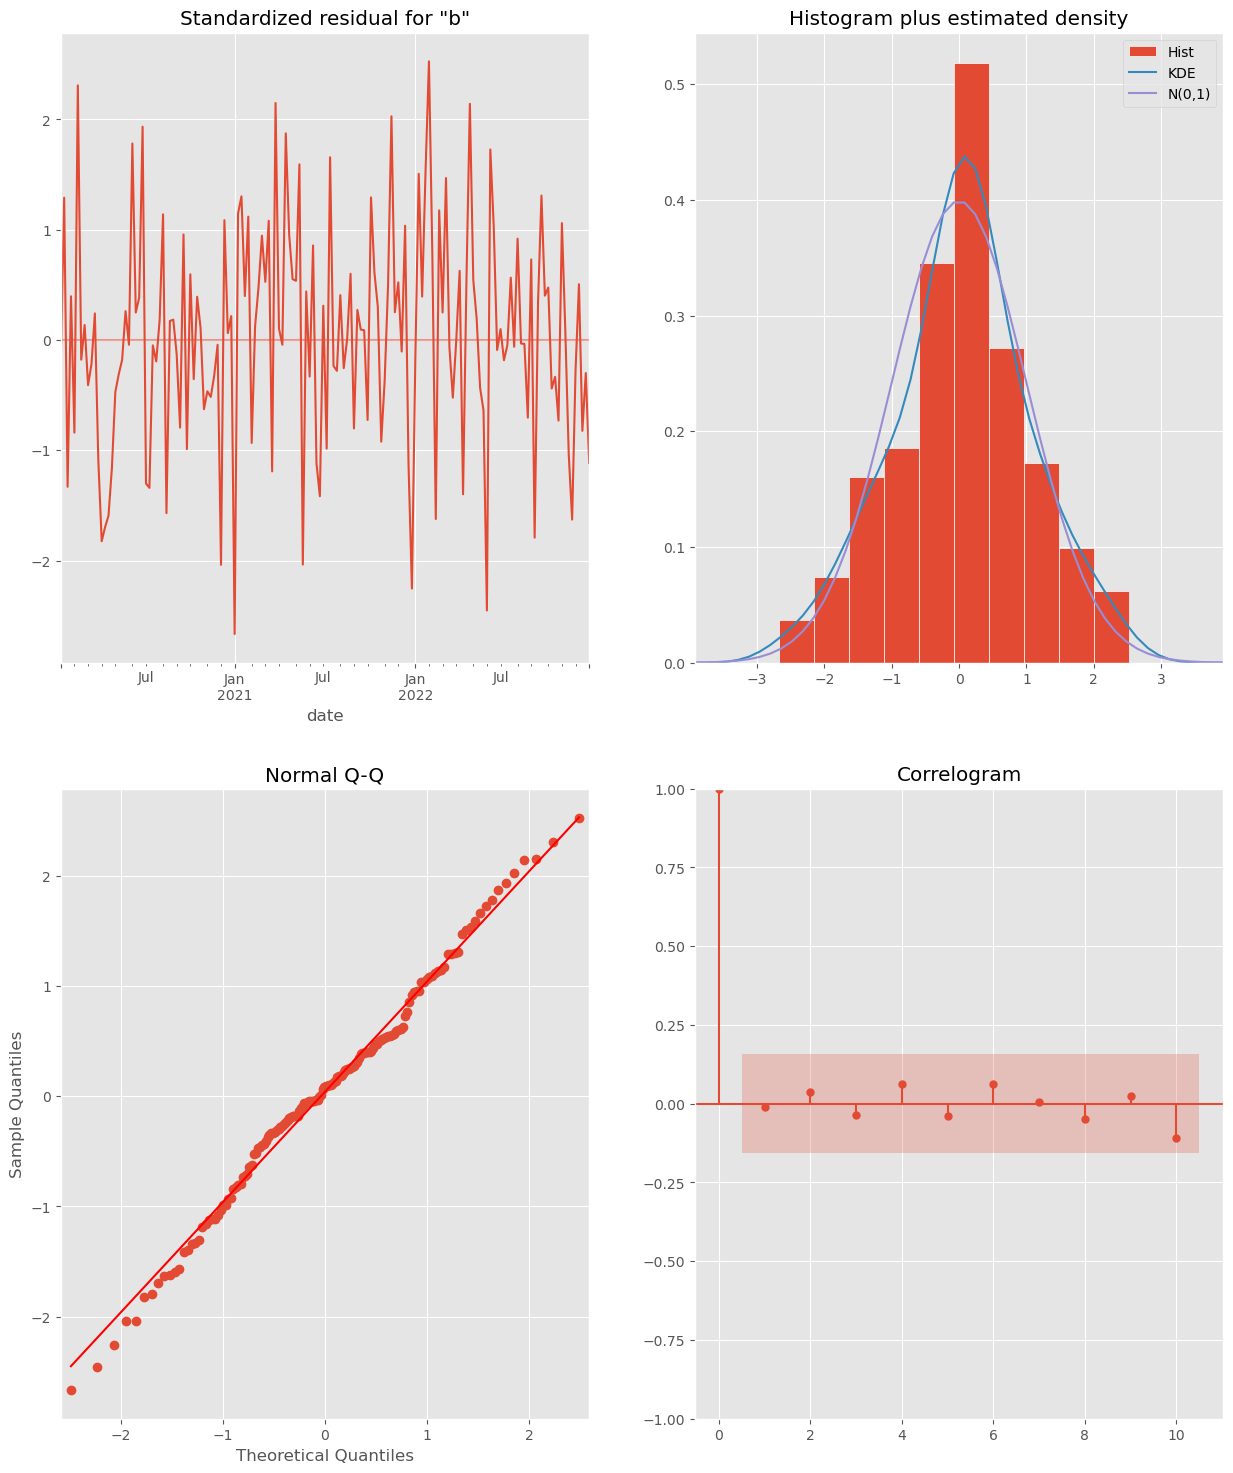

In [178]:
output.plot_diagnostics(figsize=(15, 18))
plt.show()

In [179]:
pred = output.get_prediction(start=pd.to_datetime('2022-01-07'), dynamic=False)
pred_conf = pred.conf_int()

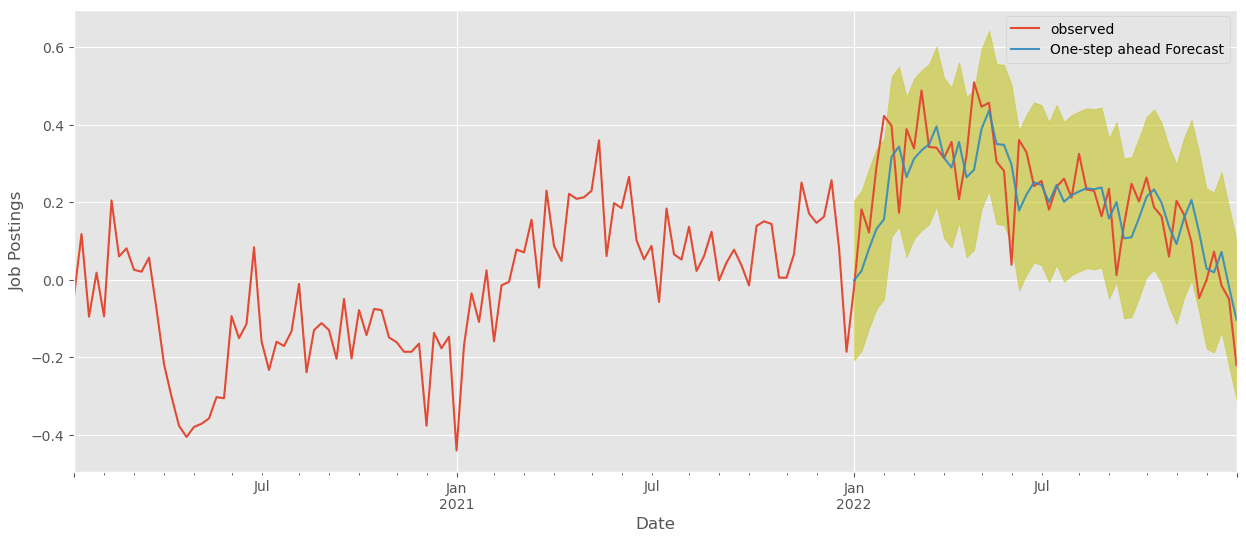

In [180]:
# Plot real vs predicted values along with confidence interval
rcParams['figure.figsize'] = 15, 6 #matplotlib runtime configuration

# Plot observed values
ax = df.plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='y', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Job Postings')
plt.legend()

plt.show()

In [181]:
# Get the real and predicted values
jobs_forecasted = pred.predicted_mean
jobs_truth = df['2022-01-07':]

# Compute the mean square error
mse = ((jobs_forecasted - jobs_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.01


In [147]:
jobs_forecasted[1] - jobs_truth[1]

-0.15903581837169062

In [182]:
# Get forecast 1yr ahead in future
prediction = output.get_forecast(steps=52)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

In [544]:
#forecast = output.predict(start=df.shape[0], end=df.shape[0] + 8)
#forecast

In [183]:
prediction.predicted_mean[:10]

2023-01-06   -0.114719
2023-01-13   -0.055429
2023-01-20   -0.066422
2023-01-27   -0.015941
2023-02-03    0.023354
2023-02-10    0.021015
2023-02-17   -0.034971
2023-02-24    0.026671
2023-03-03    0.017052
2023-03-10    0.060688
Freq: W-FRI, Name: predicted_mean, dtype: float64

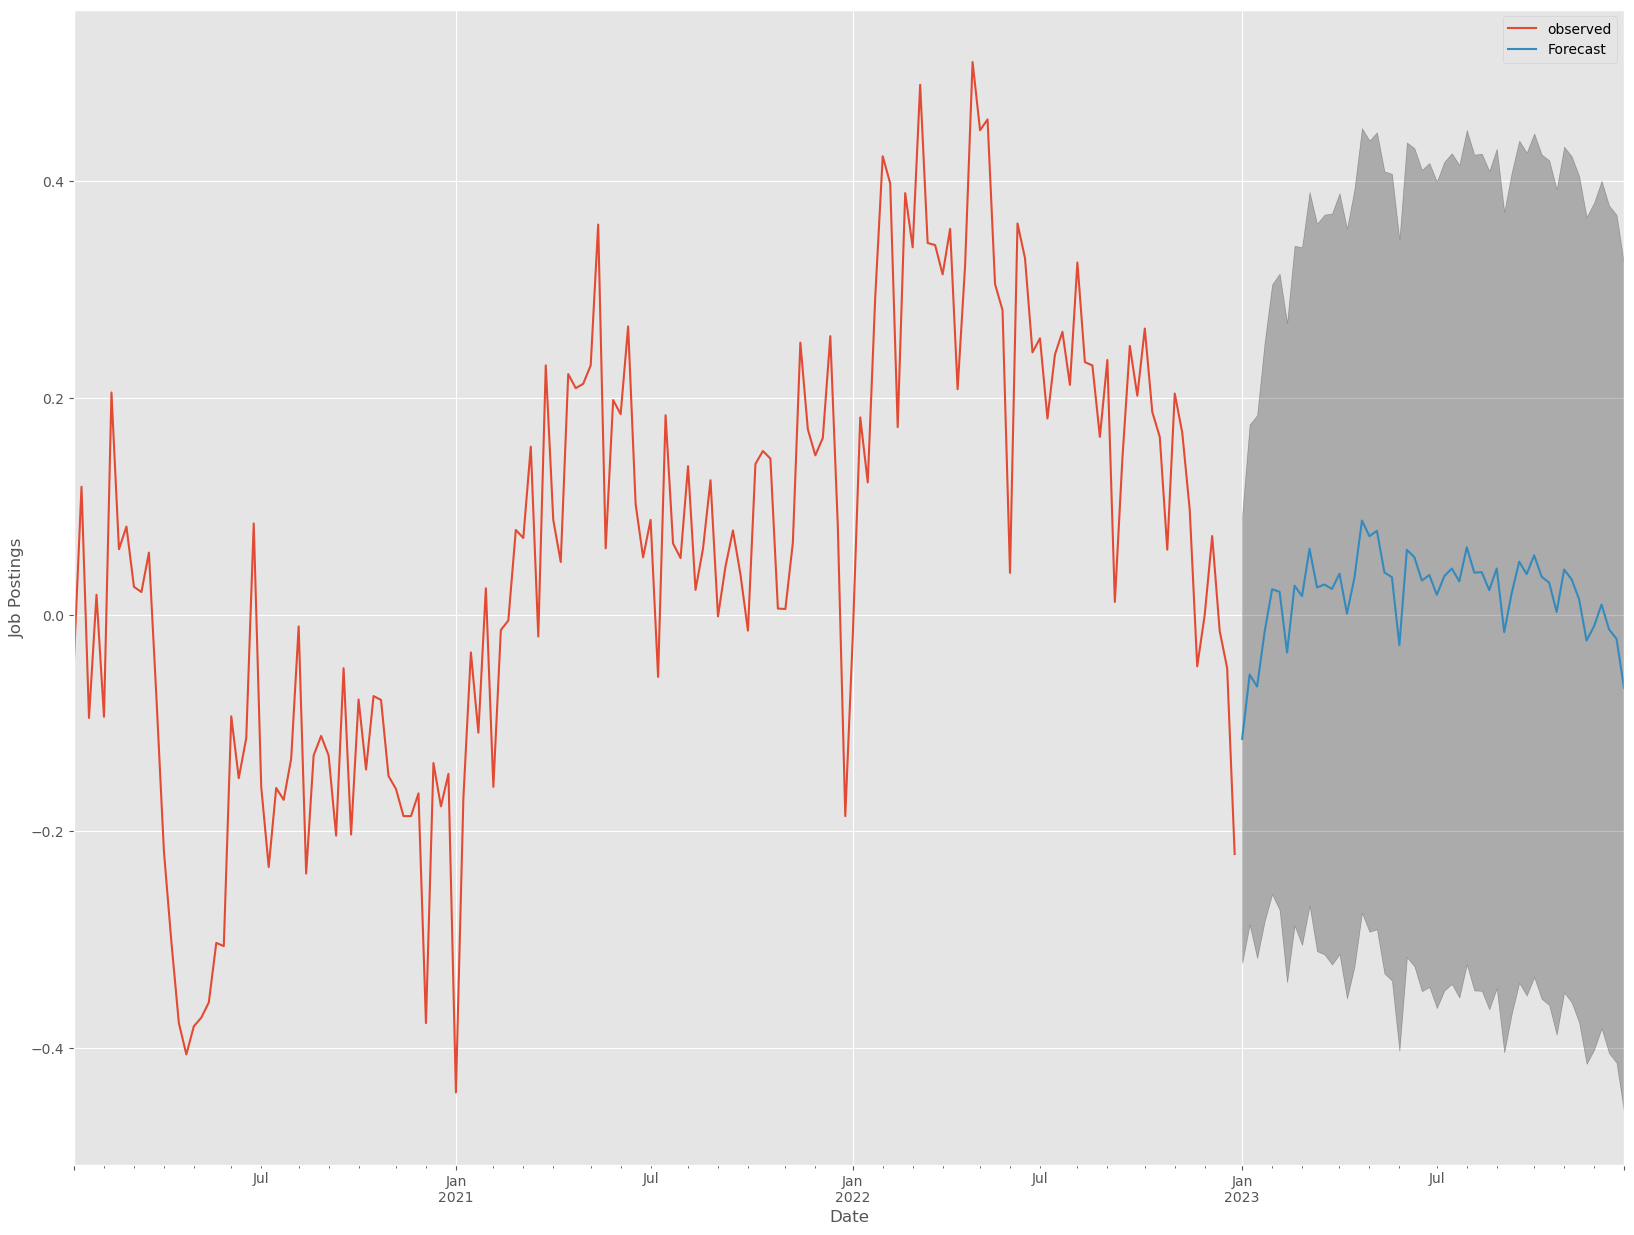

In [184]:
# Plot future predictions with confidence intervals
ax = df.plot(label='observed', figsize=(20, 15))

prediction.predicted_mean.plot(ax=ax, label='Forecast')

ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)

ax.set_xlabel('Date')
ax.set_ylabel('Job Postings')

plt.legend()
plt.show()

#### Train Test Split

In [187]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

#statsmodels
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [67]:
df.head() # weekly data

date
2020-01-10   -0.0407
2020-01-17    0.1180
2020-01-24   -0.0954
2020-01-31    0.0183
2020-02-07   -0.0943
Freq: W-FRI, Name: bg_posts, dtype: float64

In [68]:
# data needs to stay in chronological order so we cut off last 80% and set aside for test
cutoff = round(df.shape[0]*0.8) 
cutoff

125

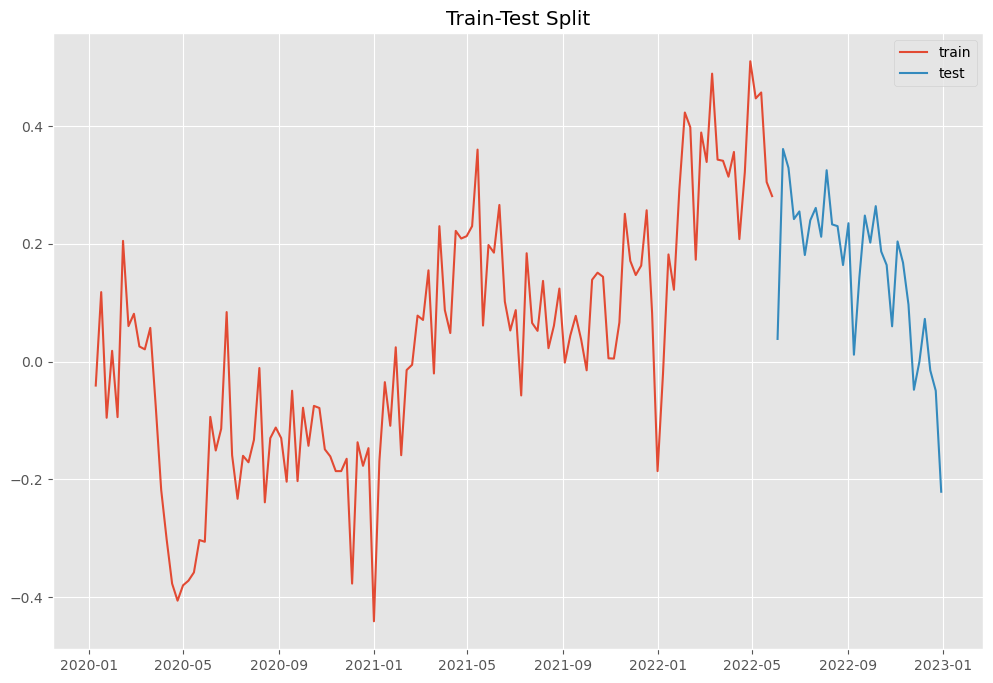

In [91]:
# train test split
train = df[:cutoff]
test = df[cutoff:]

# visualizing split
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(train, label='train')
ax.plot(test, label='test')
ax.set_title('Train-Test Split');
plt.legend();

In [92]:
split = TimeSeriesSplit()

for train_ind, val_ind in split.split(train):
    print(train_ind, val_ind)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24] [25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44] [45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64] [65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84] [ 85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102
 103 104]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13

In [93]:
train_with_ind = train.reset_index()

In [185]:
order_52

(1, 0, 1)

In [188]:
for train_ind, val_ind in split.split(train_with_ind):
    ar = ARIMA(endog=train_with_ind.iloc[train_ind, -1], order=(1, 0, 1)).fit()
    preds = ar.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    print(np.sqrt(mean_squared_error(true, preds)))

0.11623070392021657
0.1658068259880681
0.18453464278901135
0.1281475316229865
0.37522835264206783


In [190]:
for train_ind, val_ind in split.split(train_with_ind):
    ar = ARIMA(endog=train_with_ind.iloc[train_ind, -1], order=(0, 1, 2)).fit()
    preds = ar.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    print(np.sqrt(mean_squared_error(true, preds)))

0.21855766439680074
0.19926201742447877
0.09911119738964623
0.10524074295630546
0.3981136068001826


In [189]:
for train_ind, val_ind in split.split(train_with_ind):
    ar = ARIMA(endog=train_with_ind.iloc[train_ind, -1], order=(2, 1, 2)).fit()
    preds = ar.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    print(np.sqrt(mean_squared_error(true, preds)))

0.30261965367816046
0.1954849863183548
0.10282301812443947
0.10566157420918747
0.3873463613596733


Our differenced series shows negative significant correlation at a lag of 1, which suggests adding 1 MA term

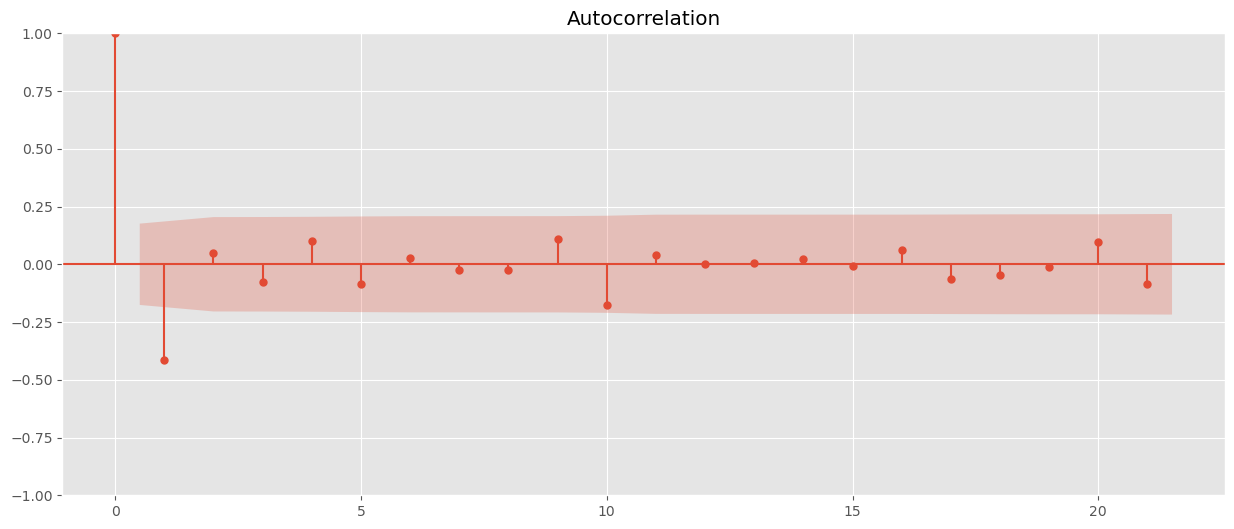

In [193]:
plot_acf(train.diff().dropna()); # 1 lag

- A sharp drop after lag "k" suggests an AR-k model. In this case, k=1
- A gradual decline suggests an MA.

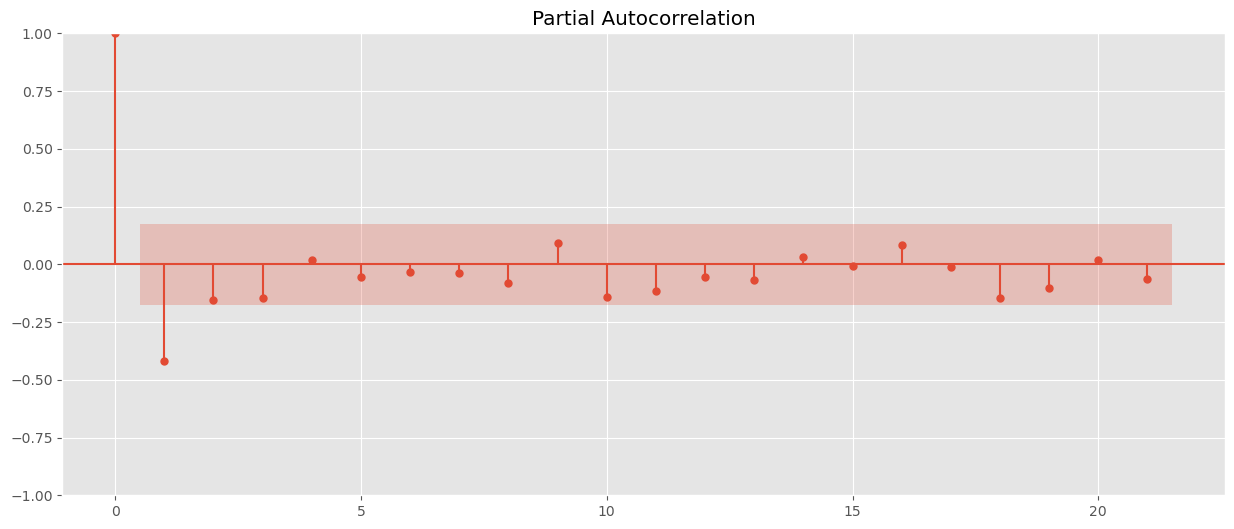

In [191]:
plot_pacf(train.diff().dropna()); 

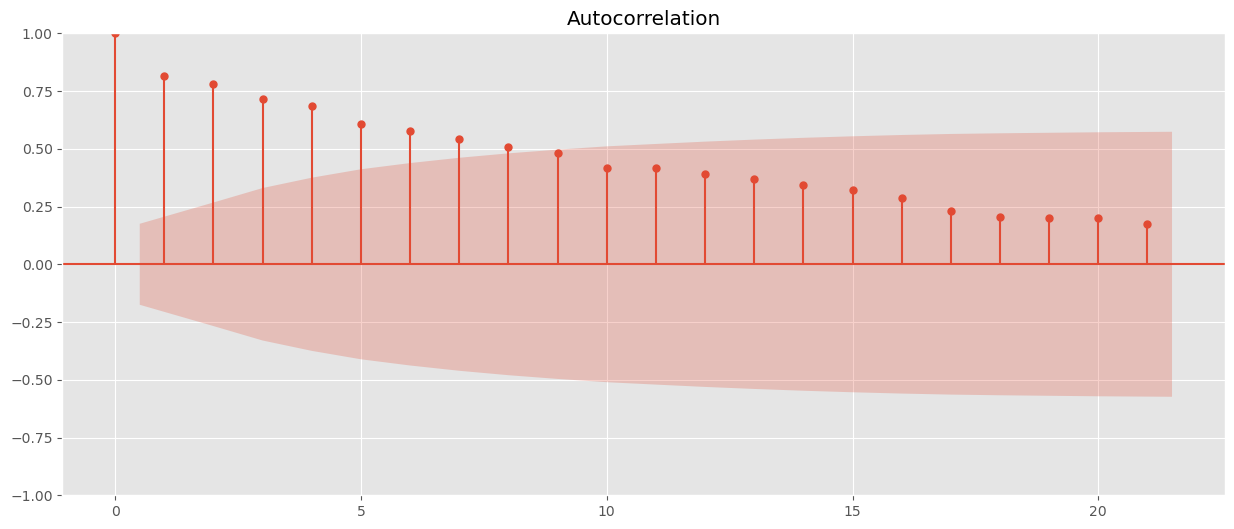

In [192]:
plot_acf(train); # period of 9-10 weeks

In [94]:
def find_rmse_test(model, test_data=test):
    y_hat = model.predict(start=test_data.index[0], end=test_data.index[-1], typ='levels')
    return np.sqrt(mean_squared_error(test_data, y_hat))

In [83]:
print(order)
seasonal_order

(1, 0, 1)


(1, 0, 0, 52)

In [78]:
sari_mod = sm.tsa.statespace.SARIMAX(train,
                                     order=order,
                                     seasonal_order=seasonal_order,
                                     enforce_stationarity=True,
                                     enforce_invertibility=True).fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.57395D-01    |proj g|=  1.81562D-01

At iterate    5    f= -7.87491D-01    |proj g|=  2.13594D-02

At iterate   10    f= -7.87852D-01    |proj g|=  6.87789D-02

At iterate   15    f= -7.87870D-01    |proj g|=  6.99364D-03

At iterate   20    f= -7.88014D-01    |proj g|=  3.48942D-02

At iterate   25    f= -7.88384D-01    |proj g|=  8.53734D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     33      1     0     0   

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                            bg_posts   No. Observations:                  125
Model:             SARIMAX(1, 0, 1)x(1, 0, [], 52)   Log Likelihood                  98.548
Date:                             Fri, 20 Jan 2023   AIC                           -189.096
Time:                                     15:47:10   BIC                           -177.783
Sample:                                 01-10-2020   HQIC                          -184.500
                                      - 05-27-2022                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9536      0.031     30.506      0.000       0.892       1.015
ma.L1         -0.4428      0.091     -4.870      0.000      -0.621      -0.265
ar.S.L52       0.2578      0.099      2.594      0.009       0.063       0.453
sigma2         0.0116      0.002      7.627      0.000       0.009       0.015
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):                 0.10
Prob(Q):                              0.75   Prob(JB):                         0.95
Heteroskedasticity (H):               1.10   Skew:                            -0.06
Prob(H) (two-sided):                  0.76   Kurtosis:                         2.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

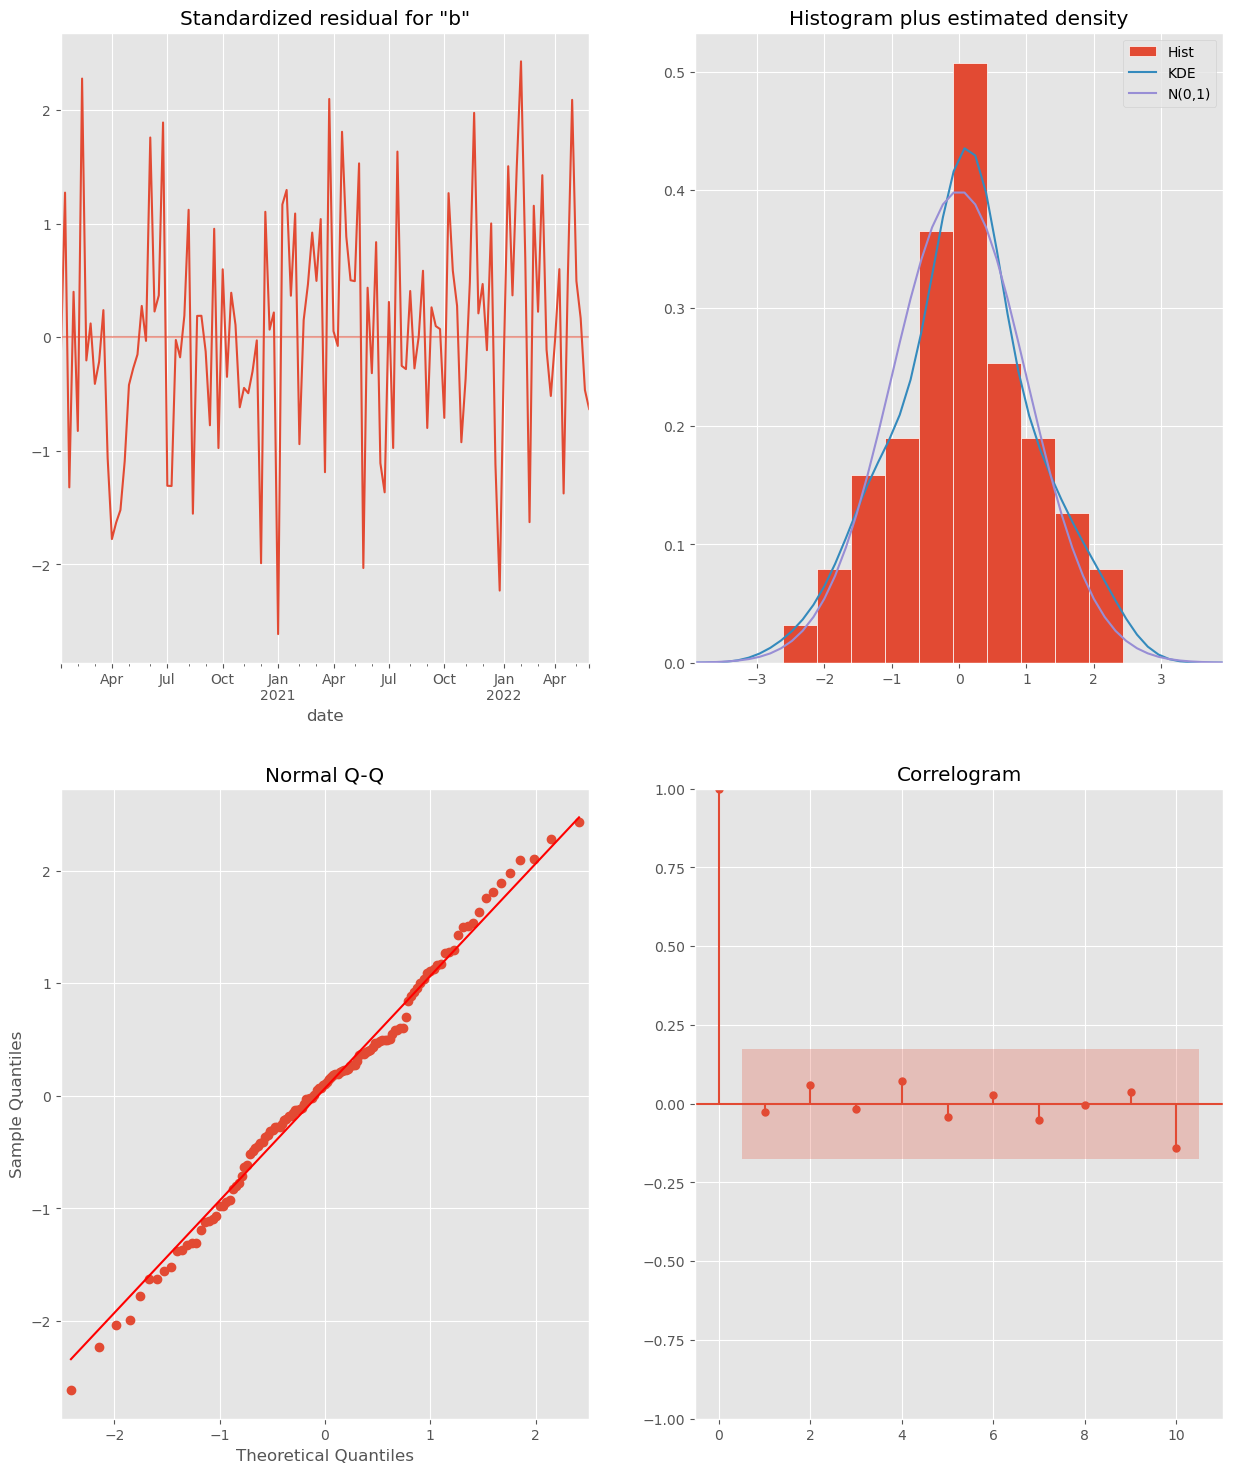

In [80]:
display(sari_mod.summary())
sari_mod.plot_diagnostics(figsize=(15, 18))
plt.show()

In [85]:
for train_ind, val_ind in split.split(train_with_ind):
    sarimax = sm.tsa.statespace.SARIMAX(endog=train_with_ind.iloc[train_ind, -1],
                                        order=order,
                                        seasonal_order=seasonal_order,
                                        enforce_stationarity=True,
                                        enforce_invertibility=True).fit()
    preds = sarimax.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    print(np.sqrt(mean_squared_error(true, preds)))

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.36034D-01    |proj g|=  2.84622D-01

At iterate    5    f= -7.47531D-01    |proj g|=  3.68861D-02


 This problem is unconstrained.



At iterate   10    f= -7.47583D-01    |proj g|=  8.33238D-02

At iterate   15    f= -7.48238D-01    |proj g|=  1.26080D-01

At iterate   20    f= -7.48323D-01    |proj g|=  2.50767D-03

At iterate   25    f= -7.48331D-01    |proj g|=  1.42408D-02

At iterate   30    f= -7.48338D-01    |proj g|=  5.94457D-03

At iterate   35    f= -7.48353D-01    |proj g|=  1.67998D-03

At iterate   40    f= -7.48366D-01    |proj g|=  4.19140D-02

At iterate   45    f= -7.48390D-01    |proj g|=  3.71745D-02

At iterate   50    f= -7.48399D-01    |proj g|=  7.10407D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     74   

 This problem is unconstrained.



At iterate    5    f= -8.41855D-01    |proj g|=  2.61449D-01

At iterate   10    f= -8.42202D-01    |proj g|=  1.07537D-04

At iterate   15    f= -8.42209D-01    |proj g|=  4.45293D-03

At iterate   20    f= -8.42218D-01    |proj g|=  2.34799D-02

At iterate   25    f= -8.42231D-01    |proj g|=  8.18870D-03

At iterate   30    f= -8.42245D-01    |proj g|=  1.61671D-02

At iterate   35    f= -8.42252D-01    |proj g|=  3.14138D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     37     62      1     0     0   5.318D-03  -8.423D-01
  F = -0.84225329873346655     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
0.14395392598863074
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.69879D-01    |proj g|=  1.86508D-01

At iterate    5    f= -7.74176D-01    |proj g|=  3.40342D-01

At iterate   10    f= -7.75051D-01    |proj g|=  2.73373D-01

At iterate   15    f= -7.77863D-01    |proj g|=  


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     45      1     0     0   2.352D-04  -7.788D-01
  F = -0.77877595340983152     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
0.15686205745801654
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.37608D-01    |proj g|=  4.70600D-01

At iterate    5    f= -7.93782D-01    |proj g|=  5.44017D-01

At iterate   10    f= -7.96424D-01    |proj g|=  1.48459D-01

At iterate   15    f= -7.96516D-01    |proj g|=  

 This problem is unconstrained.



At iterate    5    f= -7.47029D-01    |proj g|=  2.23365D+00

At iterate   10    f= -8.01300D-01    |proj g|=  1.00880D-01

At iterate   15    f= -8.08717D-01    |proj g|=  9.22865D-01

At iterate   20    f= -8.12397D-01    |proj g|=  1.55225D-02

At iterate   25    f= -8.12792D-01    |proj g|=  1.69314D-01

At iterate   30    f= -8.13138D-01    |proj g|=  2.49090D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     36      1     0     0   2.634D-06  -8.131D-01
  F = -0.81313754848789310     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
0.3239794163805492


In [89]:
test

date
2022-06-03    0.038500
2022-06-10    0.361000
2022-06-17    0.329000
2022-06-24    0.242000
2022-07-01    0.255000
2022-07-08    0.181000
2022-07-15    0.240000
2022-07-22    0.261000
2022-07-29    0.212000
2022-08-05    0.325000
2022-08-12    0.233000
2022-08-19    0.230000
2022-08-26    0.164000
2022-09-02    0.235000
2022-09-09    0.011700
2022-09-16    0.143000
2022-09-23    0.248000
2022-09-30    0.202000
2022-10-07    0.264000
2022-10-14    0.187000
2022-10-21    0.164000
2022-10-28    0.059900
2022-11-04    0.204000
2022-11-11    0.168000
2022-11-18    0.096900
2022-11-25   -0.047800
2022-12-02   -0.000331
2022-12-09    0.072500
2022-12-16   -0.015000
2022-12-23   -0.049500
2022-12-30   -0.221000
Freq: W-FRI, Name: bg_posts, dtype: float64

In [95]:
valid = train[val_ind[0]:]
valid

date
2022-01-14    0.182
2022-01-21    0.122
2022-01-28    0.293
2022-02-04    0.423
2022-02-11    0.398
2022-02-18    0.173
2022-02-25    0.389
2022-03-04    0.339
2022-03-11    0.489
2022-03-18    0.343
2022-03-25    0.341
2022-04-01    0.314
2022-04-08    0.356
2022-04-15    0.208
2022-04-22    0.322
2022-04-29    0.510
2022-05-06    0.447
2022-05-13    0.457
2022-05-20    0.305
2022-05-27    0.281
Freq: W-FRI, Name: bg_posts, dtype: float64

In [96]:
train.tail()

date
2022-04-29    0.510
2022-05-06    0.447
2022-05-13    0.457
2022-05-20    0.305
2022-05-27    0.281
Freq: W-FRI, Name: bg_posts, dtype: float64

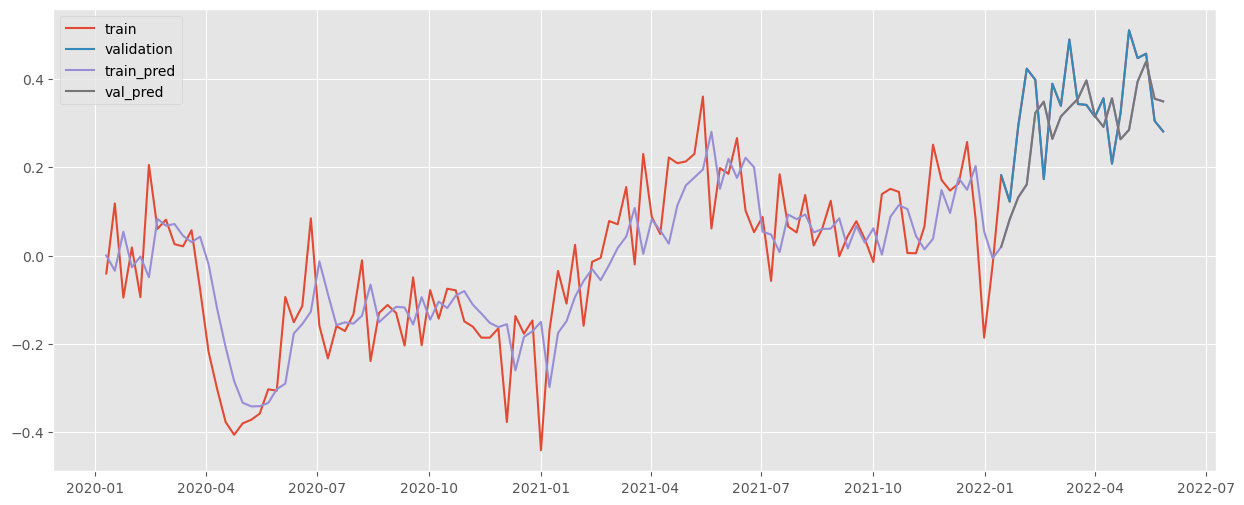

In [97]:
y_hat_train = sari_mod.predict(typ='levels')
y_hat_val = sari_mod.predict(start=val_ind[0], end=val_ind[-1],typ='levels')

fig, ax = plt.subplots()
ax.plot(train, label='train')
ax.plot(valid, label='validation') # valid
ax.plot(y_hat_train, label='train_pred')
ax.plot(y_hat_val, label='val_pred')

plt.legend();

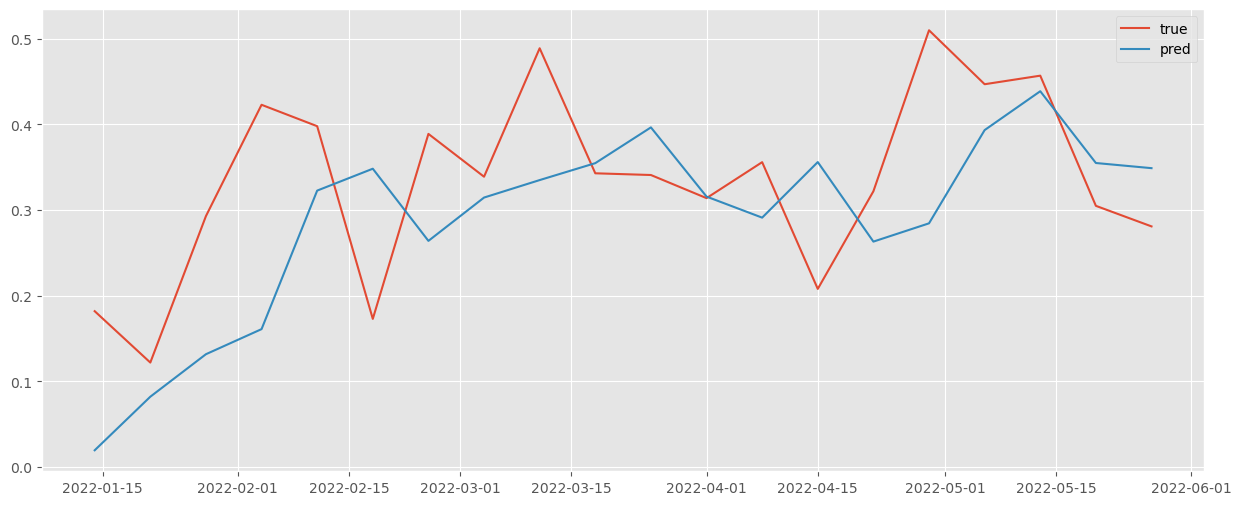

In [98]:
# Let's zoom in on validation
fig, ax = plt.subplots()

ax.plot(valid, label='true')
ax.plot(y_hat_val, label='pred')

plt.legend();

In [103]:
np.sqrt(mean_squared_error(valid, y_hat_val))

0.12100707023898231

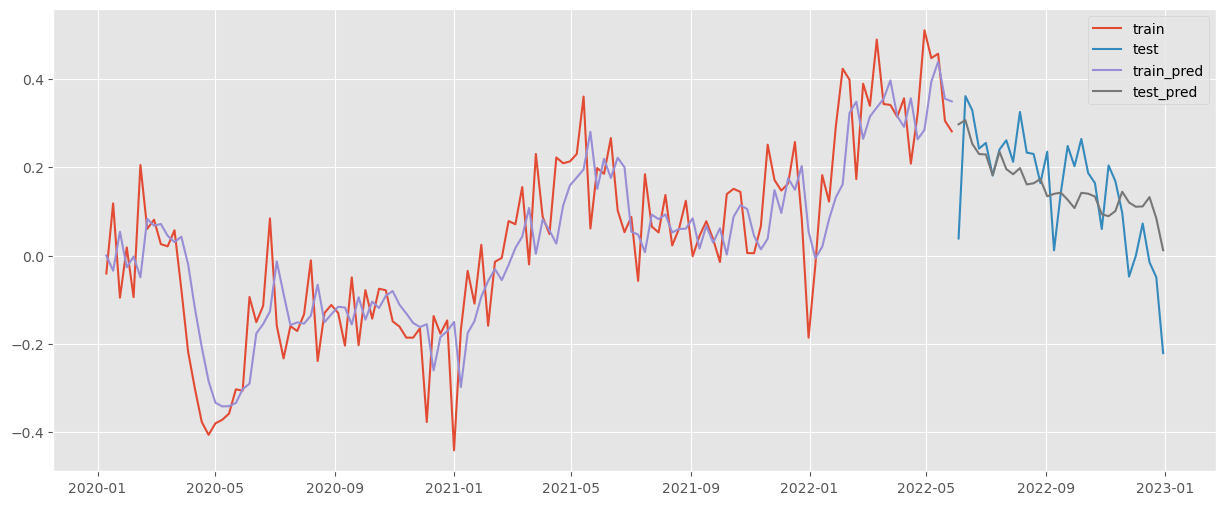

In [100]:
y_hat_train = sari_mod.predict(typ='levels')
y_hat_test = sari_mod.predict(start=test.index[0], end=test.index[-1],typ='levels')

fig, ax = plt.subplots()
ax.plot(train, label='train')
ax.plot(test, label='test') # valid
ax.plot(y_hat_train, label='train_pred')
ax.plot(y_hat_test, label='test_pred')

plt.legend();

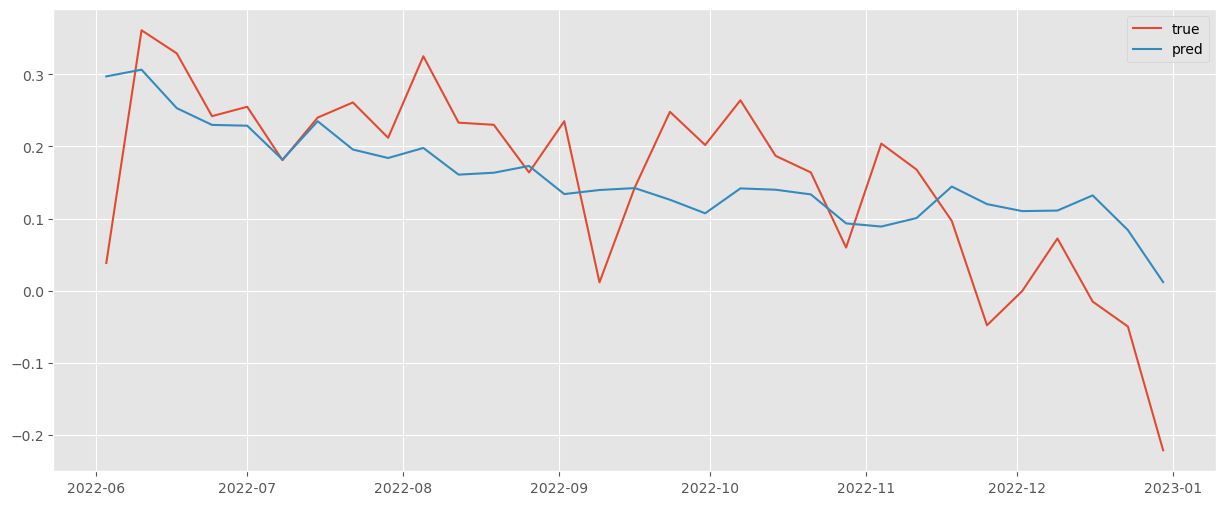

In [101]:
# Let's zoom in on validation
fig, ax = plt.subplots()

ax.plot(test, label='true')
ax.plot(y_hat_test, label='pred')

plt.legend();

In [102]:
np.sqrt(mean_squared_error(test, y_hat_test))

0.10358723013923056

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.02648D-01    |proj g|=  4.23456D-01

At iterate    5    f= -8.12667D-01    |proj g|=  2.18992D-02

At iterate   10    f= -8.12701D-01    |proj g|=  7.55498D-02

At iterate   15    f= -8.12755D-01    |proj g|=  1.08171D-03

At iterate   20    f= -8.12767D-01    |proj g|=  1.90905D-02

At iterate   25    f= -8.12834D-01    |proj g|=  1.09846D-02

At iterate   30    f= -8.12835D-01    |proj g|=  1.40499D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

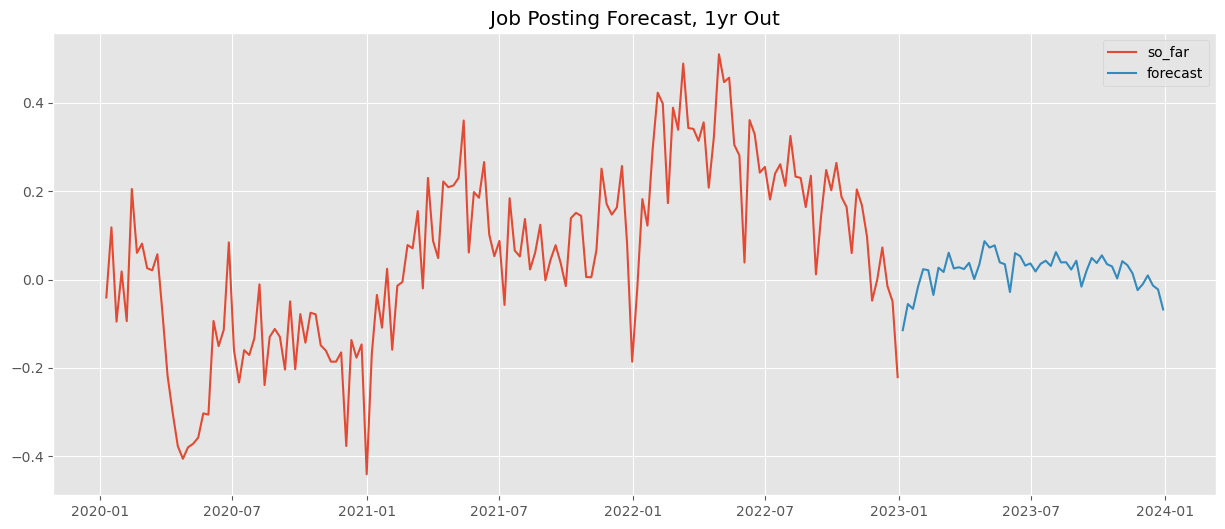

In [105]:
# Forecast

sari_mod_final = sm.tsa.statespace.SARIMAX(df,
                                           order=order,
                                           seasonal_order=seasonal_order,
                                           enforce_stationarity=True,
                                           enforce_invertibility=True).fit()

forecast = sari_mod_final.forecast(steps=52)

fig, ax = plt.subplots()
ax.plot(df, label='so_far')
ax.plot(forecast, label='forecast')
ax.set_title('Job Posting Forecast, 1yr Out')

plt.legend();

#### Facebook Prophet Model

In [408]:
from prophet import Prophet

In [565]:
df_prophet = job_postings_national[['date', 'bg_posts']]
df_prophet = df_prophet.rename(columns={'date': 'ds', 'bg_posts': 'y'})

In [566]:
Model = Prophet(interval_width=0.95)
Model.fit(df_prophet)

17:37:42 - cmdstanpy - INFO - Chain [1] start processing
17:37:42 - cmdstanpy - INFO - Chain [1] done processing


In [567]:
future_dates = Model.make_future_dataframe(periods=52, freq='W-SAT')
future_dates.tail()

ds
203 2023-11-25
204 2023-12-02
205 2023-12-09
206 2023-12-16
207 2023-12-23

In [568]:
# Predict the values for future dates and take the head of forecast
forecast = Model.predict(future_dates)
forecast.head()

ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2020-01-10 -0.208884   -0.552839   -0.074961    -0.208884    -0.208884   
1 2020-01-17 -0.205506   -0.388145    0.061553    -0.205506    -0.205506   
2 2020-01-24 -0.202128   -0.311618    0.149671    -0.202128    -0.202128   
3 2020-01-31 -0.198749   -0.289169    0.154841    -0.198749    -0.198749   
4 2020-02-07 -0.195371   -0.323479    0.156889    -0.195371    -0.195371   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0       -0.097315             -0.097315             -0.097315 -0.097315   
1        0.039271              0.039271              0.039271  0.039271   
2        0.119544              0.119544              0.119544  0.119544   
3        0.126872              0.126872              0.126872  0.126872   
4        0.108079              0.108079              0.108079  0.108079   

   yearly_lower  yearly_upper  multiplicative_terms  \
0     -0.097315     -0.097315                   0.0   
1      0.039271      0.039271                   0.0   
2      0.119544      0.119544                   0.0   
3      0.126872      0.126872                   0.0   
4      0.108079      0.108079                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0 -0.306200  
1                         0.0                         0.0 -0.166235  
2                         0.0                         0.0 -0.082583  
3                         0.0                         0.0 -0.071877  
4                         0.0                         0.0 -0.087291

In [569]:
# Subset above mentioned columns and view the tail 
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds      yhat  yhat_lower  yhat_upper
203 2023-11-25  0.343216    0.098608    0.588175
204 2023-12-02  0.360484    0.121522    0.600604
205 2023-12-09  0.361987    0.127966    0.602158
206 2023-12-16  0.320453    0.080495    0.552397
207 2023-12-23  0.259500    0.007886    0.499737

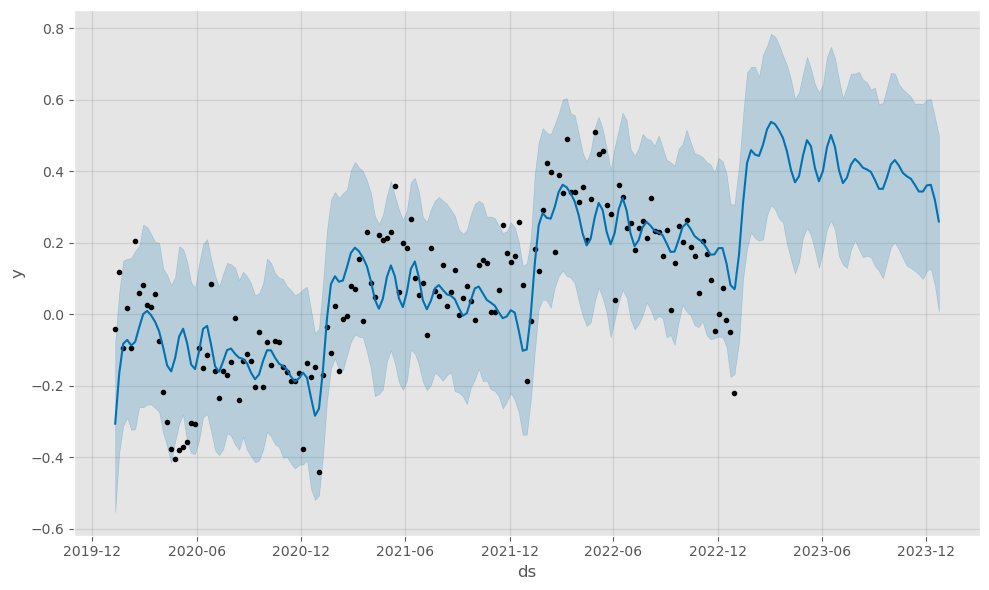

In [570]:
# Use Prophet's plot method to plot the predictions
Model.plot(forecast, uncertainty=True)
plt.show()

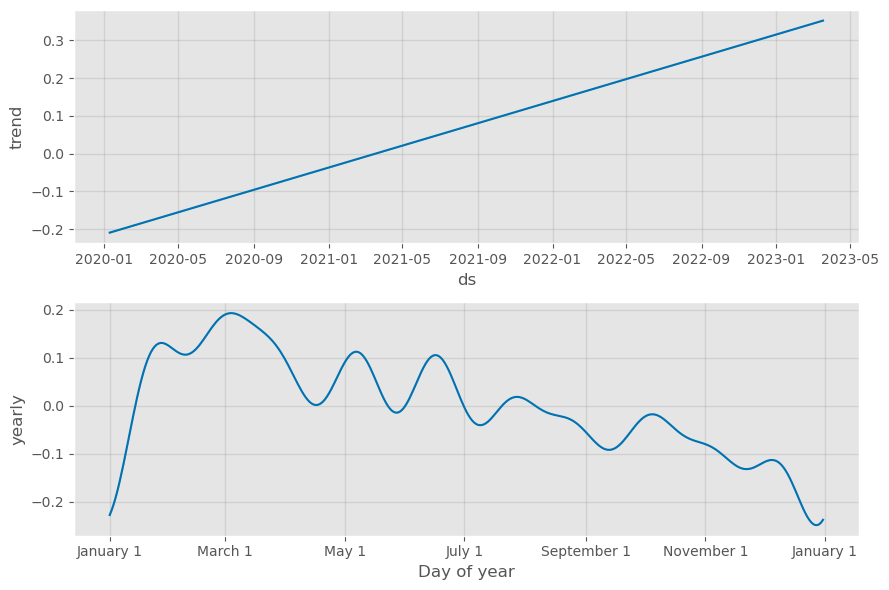

In [416]:
# Plot model components 
Model.plot_components(forecast)
plt.show()

#### ARMA Test

In [580]:
data_diff = df.diff().dropna()
data_diff

date
2020-01-17    0.158700
2020-01-24   -0.213400
2020-01-31    0.113700
2020-02-07   -0.112600
2020-02-14    0.299300
                ...   
2022-12-02    0.047469
2022-12-09    0.072831
2022-12-16   -0.087500
2022-12-23   -0.034500
2022-12-30   -0.171500
Freq: W-FRI, Name: bg_posts, Length: 155, dtype: float64

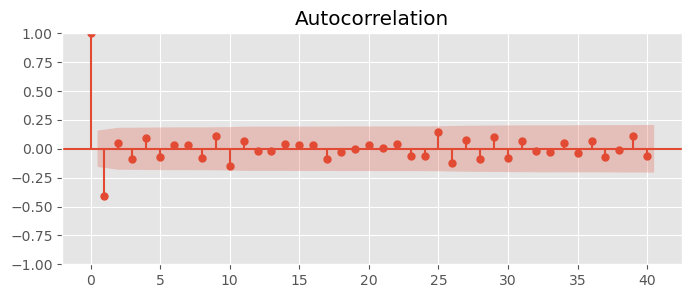

In [594]:
# Plot the ACF
from statsmodels.graphics.tsaplots import plot_acf
fig, ax = plt.subplots(figsize=(8,3))
plot_acf(data_diff,ax=ax, lags=40);

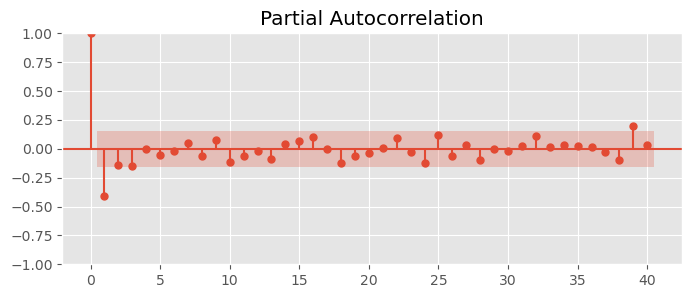

In [595]:
# Plot the PACF
from statsmodels.graphics.tsaplots import plot_pacf
fig, ax = plt.subplots(figsize=(8,3))
plot_pacf(data_diff,ax=ax, lags=40);

In [592]:
# Import ARIMA
from statsmodels.tsa.arima.model import ARIMA

# Fit an ARMA(1,0) model
mod_arma = ARIMA(data_diff, order=(1,1,0))
res_arma = mod_arma.fit()

# Print out summary information on the fit
print(res_arma.summary())

                               SARIMAX Results                                
Dep. Variable:               bg_posts   No. Observations:                  155
Model:                 ARIMA(1, 1, 0)   Log Likelihood                  67.705
Date:                Thu, 19 Jan 2023   AIC                           -131.410
Time:                        17:58:28   BIC                           -125.337
Sample:                    01-17-2020   HQIC                          -128.943
                         - 12-30-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6679      0.058    -11.597      0.000      -0.781      -0.555
sigma2         0.0242      0.003      8.084      0.000       0.018       0.030
Ljung-Box (L1) (Q):                  10.48   Jarque-

In [601]:
# Fit an ARMA(1,0) model
mod_arma = ARIMA(data_diff, order=(0,0,1))
res_arma = mod_arma.fit()

# Print out summary information on the fit
print(res_arma.summary())

                               SARIMAX Results                                
Dep. Variable:               bg_posts   No. Observations:                  155
Model:                 ARIMA(0, 0, 1)   Log Likelihood                 120.994
Date:                Thu, 19 Jan 2023   AIC                           -235.987
Time:                        18:03:07   BIC                           -226.857
Sample:                    01-17-2020   HQIC                          -232.279
                         - 12-30-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0008      0.004     -0.172      0.863      -0.009       0.008
ma.L1         -0.5080      0.064     -7.903      0.000      -0.634      -0.382
sigma2         0.0123      0.001      8.909      0.0

#### Adding Exog

In [203]:
# start date needs to be on or after 3/15/2020
# end date needs to be on or before 12/30/2022
display(df.head())
display(df.tail())
display(df_weekly.head())
display(df_weekly.tail())

date
2020-01-10   -0.0407
2020-01-17    0.1180
2020-01-24   -0.0954
2020-01-31    0.0183
2020-02-07   -0.0943
Freq: W-FRI, Name: bg_posts, dtype: float64

date
2022-12-02   -0.000331
2022-12-09    0.072500
2022-12-16   -0.015000
2022-12-23   -0.049500
2022-12-30   -0.221000
Freq: W-FRI, Name: bg_posts, dtype: float64

day
2020-03-15     109.0
2020-03-22    1315.0
2020-03-29    6400.0
2020-04-05    6643.0
2020-04-12    6652.0
Freq: W-SUN, Name: total_laid_off, dtype: float64

day
2022-12-18     1989.0
2022-12-25      836.0
2023-01-01      150.0
2023-01-08    18392.0
2023-01-15     5358.0
Freq: W-SUN, Name: total_laid_off, dtype: float64

In [204]:
df_layoffs = layoffs[['day', 'total_laid_off']]

# Make sure that index is DatetimeIndex named "date"
if isinstance(df_layoffs.index, pd.DatetimeIndex):
    df_layoffs.index.name = 'date'
else:
    df_layoffs.rename(columns={'index':'date'}, inplace=True)
    df_layoffs.set_index('day', inplace=True)
    
    
df_layoffs = df_layoffs['total_laid_off'].resample('W-FRI').sum()
df_layoffs.head()

day
2020-03-13     109.0
2020-03-20    1315.0
2020-03-27    5473.0
2020-04-03    7480.0
2020-04-10    6742.0
Freq: W-FRI, Name: total_laid_off, dtype: float64

In [205]:
df_postings = df['2020-03-13':]
df_postings.head()

date
2020-03-13    0.0208
2020-03-20    0.0572
2020-03-27   -0.0760
2020-04-03   -0.2180
2020-04-10   -0.3020
Freq: W-FRI, Name: bg_posts, dtype: float64

In [ ]:
df_log_layoffs = df_layoffs[:'2023-01-01']
df_layoffs.tail()

In [214]:
df_log_layoffs = np.log(df_layoffs[:'2023-01-01']).fillna(value=0)

day
2022-12-02    2.143833
2022-12-09    2.167912
2022-12-16    2.031638
2022-12-23    1.906371
2022-12-30    1.611563
Freq: W-FRI, Name: total_laid_off, dtype: float64

In [218]:
mod_exog = sm.tsa.statespace.SARIMAX(endog=df_postings,
                                     exog=df_layoffs,
                                     order=order_52,
                                     seasonal_order=seasonal_order_52).fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.87238D-01    |proj g|=  4.61113D-01

At iterate    5    f= -8.15711D-01    |proj g|=  2.05640D-01

At iterate   10    f= -8.15890D-01    |proj g|=  4.44269D-02

At iterate   15    f= -8.15944D-01    |proj g|=  3.65224D-03

At iterate   20    f= -8.15944D-01    |proj g|=  1.77664D-03

At iterate   25    f= -8.15954D-01    |proj g|=  1.91002D-03

At iterate   30    f= -8.15959D-01    |proj g|=  1.20183D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

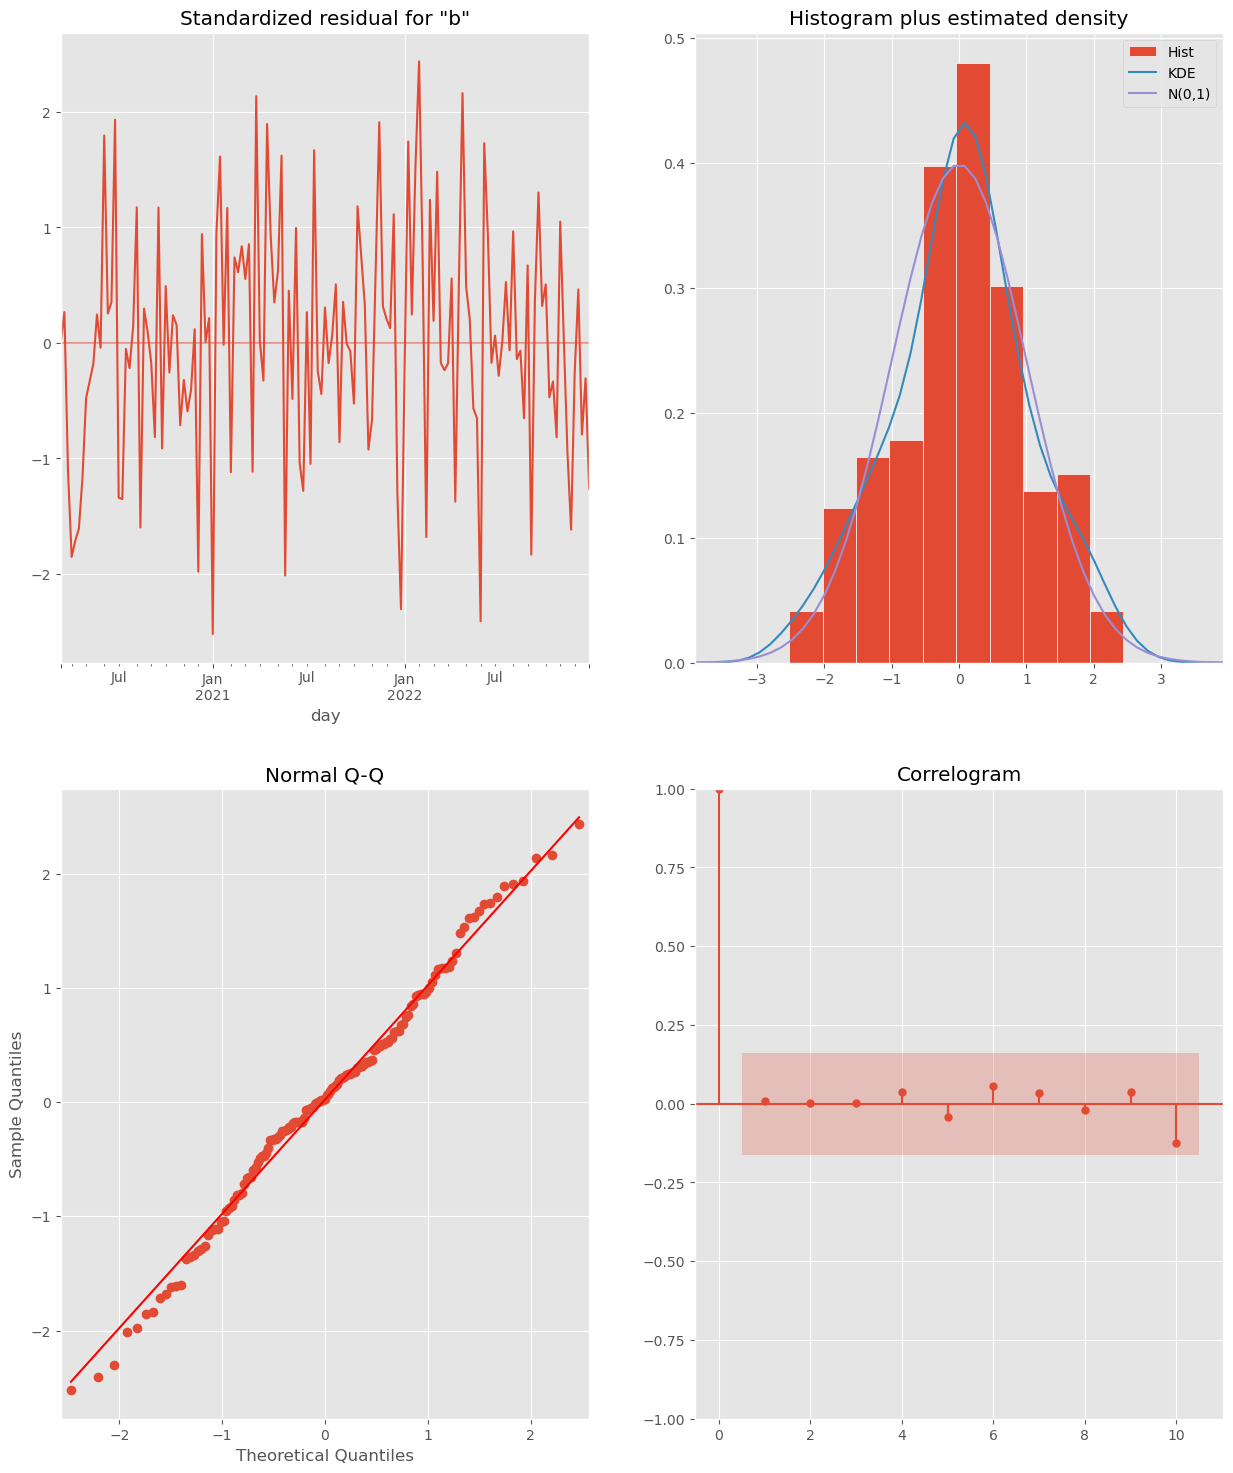

In [219]:
mod_exog.plot_diagnostics(figsize=(15, 18))
plt.show()

In [220]:
mod_exog.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                            bg_posts   No. Observations:                  147
Model:             SARIMAX(1, 0, 1)x(1, 0, [], 52)   Log Likelihood                 119.946
Date:                             Fri, 20 Jan 2023   AIC                           -229.892
Time:                                     17:24:40   BIC                           -214.940
Sample:                                 03-13-2020   HQIC                          -223.817
                                      - 12-30-2022                                         
Covariance Type:                               opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
total_laid_off     0.0130      0.014      0.904      0.366      -0.015       0.041
ar.L1              0.9524      0.026     36.804      0.000       0.902       1.003
ma.L1             -0.4495      0.076     -5.947      0.000      -0.598      -0.301
ar.S.L52           0.2168      0.092      2.348      0.019       0.036       0.398
sigma2             0.0111      0.001      8.208      0.000       0.008       0.014
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.34
Prob(Q):                              0.92   Prob(JB):                         0.84
Heteroskedasticity (H):               1.00   Skew:                            -0.11
Prob(H) (two-sided):                  0.99   Kurtosis:                         2.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [225]:
pred = mod_exog.get_prediction(start=pd.to_datetime('2022-01-07'), dynamic=False, exog=df_layoffs['2022-01-07':])
pred_conf = pred.conf_int()

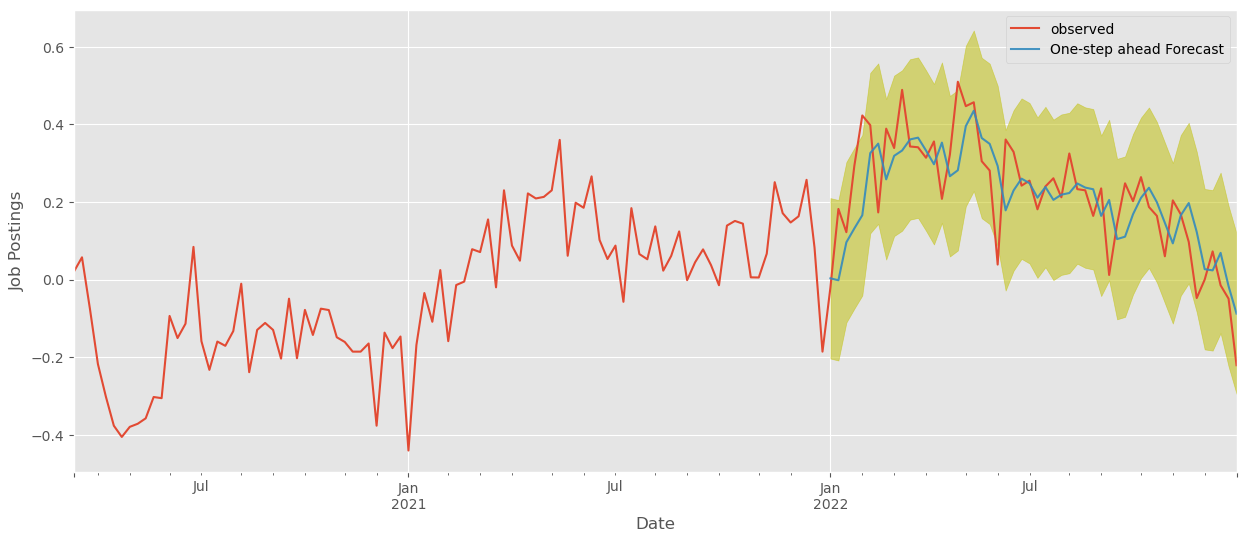

In [226]:
# Plot real vs predicted values along with confidence interval
rcParams['figure.figsize'] = 15, 6 #matplotlib runtime configuration

# Plot observed values
ax = df_postings.plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='y', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Job Postings')
plt.legend()

plt.show()

In [227]:
# Get the real and predicted values
jobs_forecasted = pred.predicted_mean
jobs_truth = df_layoffs['2022-01-07':]

# Compute the mean square error
mse = ((jobs_forecasted - jobs_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 3.09


https://github.com/statsmodels/statsmodels/issues/4284

EXOG ISSUES

In [224]:
forecast = mod_exog.predict(start=df.shape[0], end=df.shape[0] + 8, exog=df_layoffs)
forecast

ValueError: Provided exogenous values are not of the appropriate shape. Required (18, 1), got (147,).

In [221]:
# Get forecast 1yr ahead in future
prediction = mod_exog.get_forecast(steps=52)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

ValueError: Out-of-sample operations in a model with a regression component require additional exogenous values via the `exog` argument.

In [222]:
forecast = mod_exog.forecast(steps=52)

fig, ax = plt.subplots()
ax.plot(df, label='so_far')
ax.plot(forecast, label='forecast')
ax.set_title('Job Posting Forecast, 1yr Out')

plt.legend();

ValueError: Provided exogenous values are not of the appropriate shape. Required (52, 1), got (147,).

## IDEAS

- predict future layoffs, job postings: time series forecasting :)
- get rid of outliers?
- watch time series videos :)
- where are the best opportunities? by industry, company size, location 
- PCA / clustering
- NLP twitter / sentiment: keywords like "job market" "layoffs" "economy"
- correlation between layoffs and job postings
- some kind of classification 

** https://github.com/mrethana/news_bias_final **
Labeling Data
To label objective vs subjective sentences I used the part of speech tagger in NLTK to flag any sentences with specific parts of speech commonly used in subjective sentences. These included:

predeterminers (all the kids).
comparative and superlative adverb (better, best).
comparative and superlative adjectives (bigger, biggest).
I then trained a simple Naive Bayes classifier with the sentences containing these parts of speech labeled as subjective.



## EXAMPLE 

In [ ]:
fig = px.scatter(full_dataset, x="sepal width (cm)", y="sepal length (cm)", 
                 size='petal length (cm)', hover_data=['petal width (cm)'], 
                 color='class')

dash_app.layout = dcc.Graph(figure=fig)

In [ ]:
dash_app.run_server(mode="inline", height=150, host="localhost", port=5000)

In [ ]:
########## IMPORTS ##########

from flask import Flask, request
import joblib
import json

from jupyter_dash import JupyterDash as Dash
from dash import html, dcc, dash_table, Input, Output
import dash_bootstrap_components as dbc

import pandas as pd
from sklearn.datasets import load_iris

########## SETTING UP THE APPS ##########

flask_app = Flask(__name__)
external_stylesheets = [dbc.themes.BOOTSTRAP]
dash_app = Dash(__name__, external_stylesheets=external_stylesheets, server=flask_app) #,requests_pathname_prefix='/dash/') ####

########## HELPER FUNCTIONS ##########

def create_sliders(X):
    slider_items = []
    for column in X:
        label = html.H5(column)
        
        lower_bound = X[column].min()
        upper_bound = X[column].max()
        value = X[column].median()

        slider = dcc.Slider(
            min=lower_bound,
            max=upper_bound,
            value=value, # set median as default
            marks=None,
            tooltip={"always_visible": True},
            id=column # set id based on column name
        )

        item = dbc.ListGroupItem(children=[
            label,
            slider
        ])
        slider_items.append(item)
    return dbc.ListGroup(slider_items)

def create_list_group(selected_row_data):
    return dbc.ListGroup([
        dbc.ListGroupItem(f"{k}: {v}") for k, v in selected_row_data.items()
    ])

def create_image_card(selected_row_data):
    iris_class = selected_row_data["class"]
    if iris_class == 0:
        name = "Iris setosa "
        img_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/5/56/Kosaciec_szczecinkowaty_Iris_setosa.jpg/180px-Kosaciec_szczecinkowaty_Iris_setosa.jpg"
        img_source = "https://commons.wikimedia.org/wiki/File:Kosaciec_szczecinkowaty_Iris_setosa.jpg"
    elif iris_class == 1:
        name = "Iris versicolor "
        img_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/4/41/Iris_versicolor_3.jpg/320px-Iris_versicolor_3.jpg"
        img_source = "https://commons.wikimedia.org/wiki/File:Iris_versicolor_3.jpg"
    else:
        name = "Iris virginica "
        img_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/9/9f/Iris_virginica.jpg/295px-Iris_virginica.jpg"
        img_source = "https://commons.wikimedia.org/wiki/File:Iris_virginica.jpg"

    return dbc.Card(children=[
        dbc.CardImg(src=img_url),
        dbc.CardBody(children=[
            html.Em(name),
            html.Small(html.A("(image source)", href=img_source, target="blank_"))
        ])
    ])

def iris_prediction(sepal_length, sepal_width, petal_length, petal_width):
    """
    Given sepal length, sepal width, petal length, and petal width,
    predict the class of iris
    """
    with open("model.pkl", "rb") as f:
        model = joblib.load(f)
    X = [[sepal_length, sepal_width, petal_length, petal_width]]
    predictions = model.predict(X)
    # model.predict takes a list of records and returns a list of predictions
    # but we are only making a single prediction
    prediction = int(predictions[0])
    return {"predicted_class": prediction}

def check_prediction(selected_row_data):
    """
    Return an Alert component with information about the model's prediction
    vs. the true class value
    """
    data_copy = selected_row_data.copy()
    actual_class = data_copy.pop("class")
    # remove " (cm)" from labels
    data_cleaned = {k.split(" (cm)")[0].replace(" ", "_"):v for k, v in data_copy.items()}
    result = iris_prediction(**data_cleaned)
    predicted_class = result["predicted_class"]
    correct_prediction = predicted_class == actual_class
    if correct_prediction:
        color = "success"
    else:
        color = "danger"
    return dbc.Alert(f"Predicted class: {predicted_class}", color=color)

########## DECLARING LAYOUT COMPONENTS ##########

data = load_iris()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name="class")
full_dataset = pd.concat([X, y], axis=1)
fig = px.scatter(full_dataset, x="sepal width (cm)", y="sepal length (cm)", 
                 size='petal length (cm)', hover_data=['petal width (cm)'], 
                 color='class', title='Iris Features') ## NEW ##

prediction_layout = html.Div(children=[
    create_sliders(X),
    dbc.Alert("Prediction will go here", color="info", id="prediction-output")
]) 

markdown = dcc.Markdown("""
## Iris Training Dataset

Below is a DataTable showing a sample of 20 records from the
 [Iris Dataset](https://en.wikipedia.org/wiki/Iris_flower_data_set).

Select any record to view more information!
""")

table = dash_table.DataTable(
    data=full_dataset.sample(10, random_state=4).to_dict(orient="records"),
    row_selectable="single",
    cell_selectable=False,
    id="tbl"
)

modal = dbc.Modal(children=[
    dbc.ModalHeader(dbc.ModalTitle("Iris Information")),
    dbc.ModalBody(id="modal-body")
],
                  id="modal",
                  is_open=False
                 )

past_data_layout = html.Div(children=[
    html.Div(markdown),
    html.Div(table),
    modal
])

graph_layout = dcc.Graph(figure=fig) ## NEW ##

tabs = dbc.Tabs(children=[
        dbc.Tab(prediction_layout, label="Generate Predictions on New Data"),
        dbc.Tab(past_data_layout, label="Analyze Performance on Past Data"),
        dbc.Tab(graph_layout, label="Past Data Visualization") ## NEW ##
    ])

dash_app.layout = dbc.Container(children=[
    html.H1("Iris Classification Model"),
    tabs
])

########## CALLBACKS ##########

@dash_app.callback(
    Output("prediction-output", "children"),
    [
        # list comprehension to specify all of the input columns
        Input(column, "value") for column in X.columns
    ]
)
def generate_user_input_prediction(*args):
    return f"Predicted class: {iris_prediction(*args)['predicted_class']}"

@dash_app.callback(Output("modal", "is_open"), Input("tbl", "selected_rows"))
def toggle_modal(selected_rows):
    if selected_rows:
        return True
    else:
        return False

@dash_app.callback(
    Output("modal-body", "children"),
    [Input("tbl", "derived_virtual_data"), Input("tbl", "selected_rows")])
def render_information(rows, selected_rows):
    if selected_rows:
        # selection is set to "single" so there will be exactly 1 selected row
        selected_row_data = rows[selected_rows[0]]      
        return html.Div(dbc.Row(children=[
            dbc.Col(create_image_card(selected_row_data)),
            dbc.Col(children=[
                create_list_group(selected_row_data),
                html.Hr(),
                check_prediction(selected_row_data)
            ])
        ]))

########## ROUTES ##########

@flask_app.route('/predict', methods=['POST'])
def predict():
    request_json = request.get_json()
    result = iris_prediction(**request_json)
    return json.dumps(result)

In [ ]:
dash_app.run_server(mode="inline", height=150, host="localhost", port=5000)